In [1]:
import sys
directory_path = "../"
if directory_path not in sys.path:
    # Add the directory to sys.path
    sys.path.append(directory_path)

import copy
import time
import time
import numpy as np
import argparse

from torch.utils import data

from utils.utils import *
from utils import load_config
from utils.validate import *
from fedlearning.model import *
from fedlearning.dataset import *
from fedlearning.evolve import *
from fedlearning.optimizer import GlobalUpdater, LocalUpdater, get_omegas

In [2]:
config_file = "config_cluster.yaml"
config = load_config(config_file)

logger = init_logger(config)

# Init model to load # of parameters
model = init_model(config, logger)

record = init_record(config, model)

if config.device == "cuda":
    torch.backends.cudnn.benchmark = True
    # torch.backends.cudnn.deterministic = True

--------------------------------------------------------------------------------


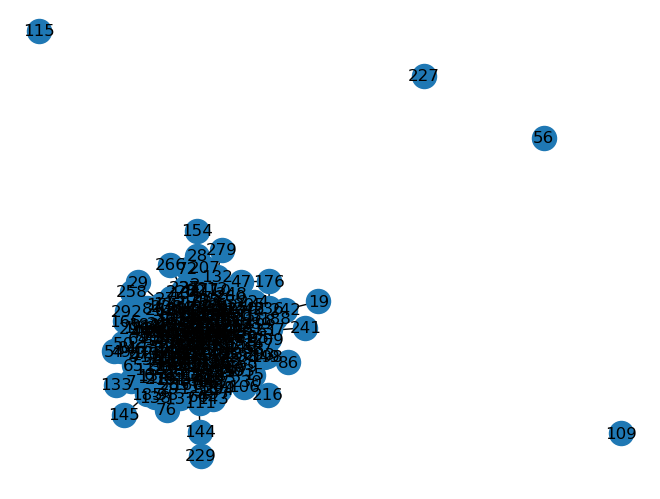

4.28

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

def create_graph(n, p, plot=False):
    # Generate the graph
    G = nx.erdos_renyi_graph(n, p)

    if plot:
        # Draw the graph
        nx.draw(G, with_labels=True)
        plt.show()
    return G

G = create_graph(config.users, 0.015, plot=True)
# Get average number of neighbors
avg_degree = np.mean([G.degree(n) for n in G.nodes])
avg_degree

In [4]:
# Create user_ids
user_ids = np.arange(0, config.users)

# load the dataset
# dataset object is a dictionary with keys: train_data, test_data, user_with_data
# user_with_data is a dictionary with keys: userID:sampleID
# For example, in the IID setting ID's are just assigned like 0, 1, 2, 3, ...
dataset = assign_user_data(config, logger)
test_images = torch.from_numpy(dataset["test_data"]["images"]).to(config.device)
test_labels = torch.from_numpy(dataset["test_data"]["labels"]).to(config.device)

# tau candidates 
taus = np.array(config.taus)

# Create a dictionary of models for each user
# Same initialization for all users

if config.same_init:
    model_dict = {model_id: copy.deepcopy(model) for model_id in user_ids}
else:
    model_dict = {model_id: init_model(config, logger) for model_id in user_ids}
# create list to store the number of connections for each user    
num_connections = [0]*config.users

In [5]:
from random_graph import average_neighbor_weights, train_client

ImportError: cannot import name 'train_client' from 'random_graph' (/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/random_graph.py)

: 

In [26]:
client_id = 7
neighbors = list(G.neighbors(client_id))
neighbors

[42, 138, 239]

In [27]:
def average_neighbor_weights(client_id, neighbor_ids, model_dict):
    # Average the weights of the models in the cluster
    weight_dict = copy.deepcopy(model_dict[client_id].state_dict())
    weight_aggregator = WeightMod(weight_dict)
    for user_id in neighbor_ids:
        weight_aggregator.add(copy.deepcopy(model_dict[user_id].state_dict()))
    # Add one for the client itself
    weight_aggregator.mul(1.0/ (len(neighbor_ids)+1) )
    return weight_aggregator.state_dict()

def load_and_deload_neighbor_weights(neighbor_ids, model_dict, avg_weight_dict):
    # Save the weights of the neighbors
    older_weight_dicts = [copy.deepcopy(model_dict[user_id].state_dict()) for user_id in neighbor_ids]
    # Load the average weights
    for user_id in neighbor_ids:
        model_dict[user_id].load_state_dict(avg_weight_dict)
    return older_weight_dicts

def reload_neighbor_weights(neighbor_ids, model_dict, old_weight_dicts):
    for i, user_id in enumerate(neighbor_ids):
        model_dict[user_id].load_state_dict(old_weight_dicts[i])


In [28]:
def train_client(client_id, neighbors, model_dict, record, config, dataset, verbose=False):
    acc = []
    losses = []
    params_list = []

    global_kernel = None
    global_xs = None
    global_ys = None
    local_packages = []
    local_kernels = []

    # Refers to the "global" jac for this client
    global_jac = None

    averaged_weight = average_neighbor_weights(client_id, neighbors, model_dict)
    # Load aggregated weights into neighbors to evaluate jacobians, f(x), and store for later reloading
    old_neighbor_weights = load_and_deload_neighbor_weights(neighbors, model_dict, averaged_weight)
    # Load weight into client as well
    model_dict[client_id].load_state_dict(averaged_weight)

    # Aggregate jacobians, x, y for each neighbor to simulate sending to current client
    # (Though in the implementation, we would send f(x) rather than x, we append x here for simplicity)
    # the +[client_id] is to include the client itself
    for user_id in neighbors+[client_id]:
        # Select the model with which to take jacobian
        model = model_dict[user_id]

        if verbose: print("user {:d} sending jacobian".format(user_id))
        # assign_user_resource specifies some parameters for the user given their user_id
        # user_resource is a dictionary with keys: lr, device, batch_size, images, labels
        user_resource = assign_user_resource(config, user_id, 
                                dataset["train_data"], dataset["user_with_data"])
        local_updater = LocalUpdater(config, user_resource)
        # Gets the local jacobians for a given client specified in local_updater
        local_updater.local_step(model)
        # Simulate uplink transmission
        local_package = local_updater.uplink_transmit()
        # Append this clients jacobians to the list
        local_packages.append(local_package)

        # Send local x and y
        if global_xs is None:
            global_xs = local_updater.xs
            global_ys = local_updater.ys
        else:
            global_xs = torch.vstack((global_xs, local_updater.xs))
            global_ys = torch.vstack((global_ys, local_updater.ys))            

        # del local_updater
        torch.cuda.empty_cache()
    reload_neighbor_weights(neighbors, model_dict, old_neighbor_weights)

    start_time = time.time()
    global_jac = combine_local_jacobians(local_packages)
    #del local_packages
    # Added these two lines to free up memory
    del local_package
    del local_updater
    if verbose: print("compute kernel matrix")
    global_kernel = empirical_kernel(global_jac)

    if verbose: print("kernel computation time {:3f}".format(time.time() - start_time))
    # Returns a function that, given t and f_0, solves for f_t
    predictor = gradient_descent_ce(global_kernel.cpu(), global_ys.cpu(), config.lr)
        
        
    # This is f^(0) (X)
    # Note: The model var still has the aggregated weight, so it can be used to evaluate the model
    # and find f0. However, in the distributed implementation, we would send the model to the client
    with torch.no_grad():
        fx_0 = model(global_xs)

    # Configure maximum t as one more than the largest tau value
    t = torch.arange(config.taus[-1]+1)

    # Create f_x using the time values and the initial f_x
    fx_train = predictor(t, fx_0.cpu())
    # fx_train = fx_train.to(fx_0)

    # Set the averaged weight as the weight to be evaluated
    init_state_dict = averaged_weight
    losses = np.zeros_like(taus, dtype=float)
    acc = np.zeros_like(taus, dtype=float)

    if verbose: print("loss \tacc")
    for i, tau in enumerate(config.taus):
        # initialize the weight aggregator with current weights
        weight_aggregator = WeightMod(init_state_dict)
        global_omegas = get_omegas(t[:tau+1], config.lr, global_jac, 
                global_ys.cpu(), fx_train[:tau+1], config.loss, 
                model.state_dict())
        # global_omegas = get_omegas(t[:tau+1], config.lr, global_jac, 
        #         global_ys, fx_train[:tau+1], config.loss, 
        #         model.state_dict())        
        
        # Complete the sum in 9b
        weight_aggregator.add(global_omegas)
        aggregated_weight = weight_aggregator.state_dict()
        model.load_state_dict(aggregated_weight)

        output = model(global_xs)    

        loss = loss_with_output(output, global_ys, config.loss)
        # loss_fx = loss_with_output(fx_train[tau].to(global_ys), global_ys, config.loss)
        losses[i] = loss

        output = model(test_images)

        test_acc = accuracy_with_output(output, test_labels)
        acc[i] = test_acc

        if verbose: print("{:.3f}\t{:.3f}".format(loss, test_acc))

        params_list.append(copy.deepcopy(aggregated_weight))

    # Get index of tau with lowest loss
    idx = np.argmin(losses)
    # Select weight parameters with lowest loss
    params = params_list[idx]

    # Select tau with lowest loss
    current_tau = taus[idx]
    current_acc = acc[idx]
    current_loss = losses[idx]

    if verbose: logger.info("current tau {:d}".format(current_tau))
    logger.info("acc {:4f}".format(current_acc))
    if verbose: logger.info("loss {:.4f}".format(current_loss))

    # Load weight into client model
    model_dict[client_id].load_state_dict(params)

    # Return the current loss, accuracy, and tau
    # record["loss"].append(current_loss)
    # record["testing_accuracy"].append(current_acc)
    # record["taus"].append(current_tau)
    torch.cuda.empty_cache()
    return current_loss, current_acc, current_tau

train_client(client_id, neighbors, model_dict, record, config, dataset, verbose=True)

user 42 sending jacobian
user 138 sending jacobian
user 239 sending jacobian
user 7 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.381621
loss 	acc
0.978	0.578
0.956	0.582
0.956	0.584
0.963	0.582
0.975	0.578
0.988	0.574
1.002	0.569
1.018	0.565
1.034	0.559
1.052	0.555
1.140	0.539


current tau 300
current tau 300
acc 0.583600
acc 0.583600
loss 0.9555
loss 0.9555


1.224	0.531


(0.9555044174194336, 0.5835999846458435, 300)

In [30]:
def complete_train(user_ids, comm_rounds, model_dict, record, config, dataset, verbose=False):
    record["loss"]  = []
    record["testing_accuracy"] = []
    record["taus"] = []
    for i in range(comm_rounds):
        print("Comm Round: ", i)
        client_losses = []
        client_accs = []
        client_taus = []
        # Train each client on neighbors + their own data
        clients_trained = 0
        for client_id in user_ids:
            neighbors = list(G.neighbors(client_id))
            print("Num neighbors: ", len(neighbors))
            loss, acc, tau = train_client(client_id, neighbors, model_dict, record, config, dataset, verbose=verbose)
            client_losses.append(loss)
            client_accs.append(acc)
            client_taus.append(tau)
            if verbose: print("client {:d} loss {:.4f} acc {:.4f} tau {:d}".format(client_id, loss, acc, tau))
            clients_trained += 1
            if clients_trained % 20 == 0 and verbose:
                print("Clients trained: ", clients_trained)
        # Create 2D array of client losses per round
        record["loss"].append(client_losses)
        record["testing_accuracy"].append(client_accs)
        record["taus"].append(client_taus)
        # Save Model Dict
        record["models"] = model_dict
        record["epoch"] = i
        # Save the record
        save_record(config, record)


    
complete_train(user_ids, 1, model_dict, record, config, dataset, verbose=True)

Num neighbors:  4
user 21 sending jacobian
user 30 sending jacobian
user 116 sending jacobian
user 164 sending jacobian
user 0 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.543432
loss 	acc
0.834	0.637
0.799	0.621
0.806	0.610
0.829	0.597
0.860	0.589
0.892	0.583
0.923	0.579
0.954	0.577
0.983	0.572
1.009	0.571
1.119	0.561


current tau 200
current tau 200
acc 0.621500
acc 0.621500
loss 0.7994
loss 0.7994


1.203	0.558
client 0 loss 0.7994 acc 0.6215 tau 200
Num neighbors:  5
user 12 sending jacobian
user 76 sending jacobian
user 126 sending jacobian
user 257 sending jacobian
user 269 sending jacobian
user 1 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.672588
loss 	acc
0.790	0.692
0.749	0.691
0.733	0.688
0.724	0.688
0.717	0.687
0.711	0.685
0.709	0.683
0.711	0.679
0.715	0.676
0.721	0.672
0.782	0.648


current tau 700
current tau 700
acc 0.682700
acc 0.682700
loss 0.7092
loss 0.7092


0.865	0.626
client 1 loss 0.7092 acc 0.6827 tau 700
Num neighbors:  6
user 107 sending jacobian
user 132 sending jacobian
user 146 sending jacobian
user 154 sending jacobian
user 155 sending jacobian
user 239 sending jacobian
user 2 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.796870
loss 	acc
0.938	0.627
0.948	0.628
0.981	0.623
1.019	0.615
1.055	0.607
1.089	0.603
1.121	0.595
1.153	0.590
1.184	0.586
1.215	0.584
1.356	0.570


current tau 100
current tau 100
acc 0.627000
acc 0.627000
loss 0.9380
loss 0.9380


1.479	0.563
client 2 loss 0.9380 acc 0.6270 tau 100
Num neighbors:  3
user 18 sending jacobian
user 34 sending jacobian
user 205 sending jacobian
user 3 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.439555
loss 	acc
0.726	0.669
0.671	0.664
0.662	0.656
0.671	0.651
0.688	0.645
0.709	0.639
0.730	0.636
0.753	0.630
0.775	0.626
0.796	0.620
0.902	0.601


current tau 300
current tau 300
acc 0.656400
acc 0.656400
loss 0.6620
loss 0.6620


0.993	0.586
client 3 loss 0.6620 acc 0.6564 tau 300
Num neighbors:  1
user 28 sending jacobian
user 4 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.204669
loss 	acc
0.537	0.699
0.480	0.704
0.477	0.697
0.498	0.689
0.530	0.676
0.568	0.663
0.607	0.651
0.647	0.637
0.686	0.626
0.724	0.614
0.896	0.579


current tau 300
current tau 300
acc 0.696900
acc 0.696900
loss 0.4774
loss 0.4774


1.041	0.555
client 4 loss 0.4774 acc 0.6969 tau 300
Num neighbors:  8
user 25 sending jacobian
user 158 sending jacobian
user 171 sending jacobian
user 196 sending jacobian
user 231 sending jacobian
user 251 sending jacobian
user 281 sending jacobian
user 283 sending jacobian
user 5 sending jacobian
compute kernel matrix
Made it!
kernel computation time 1.125658
loss 	acc
0.962	0.616
0.941	0.622
0.948	0.623
0.966	0.621
0.990	0.621
1.019	0.619
1.051	0.617
1.086	0.615
1.125	0.614
1.167	0.611
1.414	0.579


current tau 200
current tau 200
acc 0.622200
acc 0.622200
loss 0.9415
loss 0.9415


1.700	0.541
client 5 loss 0.9415 acc 0.6222 tau 200
Num neighbors:  3
user 171 sending jacobian
user 211 sending jacobian
user 261 sending jacobian
user 6 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.431469
loss 	acc
0.790	0.680
0.714	0.691
0.695	0.692
0.707	0.685
0.745	0.666
0.804	0.650
0.875	0.636
0.954	0.622
1.039	0.611
1.125	0.600
1.563	0.540


current tau 300
current tau 300
acc 0.691800
acc 0.691800
loss 0.6945
loss 0.6945


1.978	0.500
client 6 loss 0.6945 acc 0.6918 tau 300
Num neighbors:  3
user 42 sending jacobian
user 138 sending jacobian
user 239 sending jacobian
user 7 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.432164
loss 	acc
0.723	0.667
0.709	0.657
0.720	0.648
0.739	0.641
0.762	0.631
0.786	0.625
0.810	0.617
0.834	0.610
0.857	0.605
0.878	0.600
0.971	0.583


current tau 200
current tau 200
acc 0.657100
acc 0.657100
loss 0.7092
loss 0.7092


1.043	0.571
client 7 loss 0.7092 acc 0.6571 tau 200
Num neighbors:  1
user 71 sending jacobian
user 8 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.205601
loss 	acc
0.581	0.689
0.495	0.701
0.456	0.705
0.438	0.704
0.432	0.703
0.434	0.702
0.440	0.700
0.448	0.698
0.457	0.695
0.468	0.693
0.521	0.681


current tau 500
current tau 500
acc 0.702900
acc 0.702900
loss 0.4320
loss 0.4320


0.573	0.672
client 8 loss 0.4320 acc 0.7029 tau 500
Num neighbors:  2
user 31 sending jacobian
user 298 sending jacobian
user 9 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.306490
loss 	acc
0.661	0.681
0.602	0.675
0.597	0.659
0.610	0.645
0.630	0.628
0.656	0.613
0.684	0.598
0.714	0.587
0.743	0.575
0.772	0.567
0.916	0.530


current tau 300
current tau 300
acc 0.659100
acc 0.659100
loss 0.5973
loss 0.5973


1.050	0.502
client 9 loss 0.5973 acc 0.6591 tau 300
Num neighbors:  4
user 17 sending jacobian
user 97 sending jacobian
user 199 sending jacobian
user 280 sending jacobian
user 10 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.541081
loss 	acc
0.880	0.640
0.856	0.648
0.875	0.641
0.924	0.625
0.993	0.606
1.076	0.587
1.167	0.574
1.262	0.559
1.358	0.550
1.452	0.539
1.879	0.496


current tau 200
current tau 200
acc 0.648100
acc 0.648100
loss 0.8556
loss 0.8556


2.223	0.472
client 10 loss 0.8556 acc 0.6481 tau 200
Num neighbors:  3
user 181 sending jacobian
user 240 sending jacobian
user 244 sending jacobian
user 11 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.432276
loss 	acc
0.689	0.681
0.633	0.679
0.626	0.674
0.638	0.668
0.662	0.662
0.691	0.654
0.723	0.646
0.758	0.638
0.794	0.631
0.831	0.625
1.008	0.596


current tau 300
current tau 300
acc 0.673500
acc 0.673500
loss 0.6257
loss 0.6257


1.171	0.574
client 11 loss 0.6257 acc 0.6735 tau 300
Num neighbors:  5
user 1 sending jacobian
user 24 sending jacobian
user 49 sending jacobian
user 136 sending jacobian
user 233 sending jacobian
user 12 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.676227
loss 	acc
0.661	0.737
0.604	0.747
0.584	0.751
0.584	0.749
0.596	0.745
0.615	0.739
0.640	0.729
0.667	0.720
0.697	0.715
0.728	0.706
0.891	0.673


current tau 400
current tau 400
acc 0.749300
acc 0.749300
loss 0.5839
loss 0.5839


1.038	0.642
client 12 loss 0.5839 acc 0.7493 tau 400
Num neighbors:  2
user 75 sending jacobian
user 256 sending jacobian
user 13 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.318886
loss 	acc
0.984	0.564
0.947	0.562
0.954	0.557
0.977	0.549
1.006	0.545
1.038	0.541
1.069	0.538
1.101	0.535
1.131	0.532
1.161	0.530
1.287	0.522


current tau 200
current tau 200
acc 0.561500
acc 0.561500
loss 0.9471
loss 0.9471


1.383	0.515
client 13 loss 0.9471 acc 0.5615 tau 200
Num neighbors:  9
user 66 sending jacobian
user 87 sending jacobian
user 131 sending jacobian
user 174 sending jacobian
user 177 sending jacobian
user 187 sending jacobian
user 210 sending jacobian
user 218 sending jacobian
user 225 sending jacobian
user 14 sending jacobian
compute kernel matrix
Made it!
kernel computation time 1.257477
loss 	acc
1.041	0.599
1.007	0.629
1.003	0.642
1.008	0.646
1.018	0.648
1.031	0.648
1.045	0.646
1.058	0.643
1.070	0.638
1.081	0.635
1.117	0.622


current tau 300
current tau 300
acc 0.642200
acc 0.642200
loss 1.0033
loss 1.0033


1.148	0.610
client 14 loss 1.0033 acc 0.6422 tau 300
Num neighbors:  9
user 88 sending jacobian
user 111 sending jacobian
user 131 sending jacobian
user 219 sending jacobian
user 236 sending jacobian
user 238 sending jacobian
user 245 sending jacobian
user 250 sending jacobian
user 274 sending jacobian
user 15 sending jacobian
compute kernel matrix
Made it!
kernel computation time 1.058441
loss 	acc
1.068	0.571
1.138	0.558
1.249	0.549
1.357	0.544
1.458	0.540
1.553	0.534
1.642	0.526
1.726	0.517
1.805	0.510
1.880	0.504
2.209	0.466


current tau 100
current tau 100
acc 0.571400
acc 0.571400
loss 1.0684
loss 1.0684


2.492	0.428
client 15 loss 1.0684 acc 0.5714 tau 100
Num neighbors:  3
user 97 sending jacobian
user 104 sending jacobian
user 195 sending jacobian
user 16 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.378894
loss 	acc
1.064	0.553
1.074	0.561
1.117	0.553
1.174	0.538
1.237	0.526
1.306	0.517
1.377	0.509
1.449	0.501
1.520	0.493
1.590	0.486
1.913	0.470


current tau 100
current tau 100
acc 0.553300
acc 0.553300
loss 1.0638
loss 1.0638


2.184	0.463
client 16 loss 1.0638 acc 0.5533 tau 100
Num neighbors:  4
user 10 sending jacobian
user 205 sending jacobian
user 262 sending jacobian
user 265 sending jacobian
user 17 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.477334
loss 	acc
0.864	0.653
0.841	0.657
0.842	0.661
0.851	0.663
0.861	0.662
0.872	0.661
0.883	0.660
0.895	0.660
0.908	0.658
0.921	0.656
0.992	0.647


current tau 200
current tau 200
acc 0.657500
acc 0.657500
loss 0.8407
loss 0.8407


1.062	0.641
client 17 loss 0.8407 acc 0.6575 tau 200
Num neighbors:  9
user 3 sending jacobian
user 19 sending jacobian
user 67 sending jacobian
user 82 sending jacobian
user 132 sending jacobian
user 171 sending jacobian
user 188 sending jacobian
user 228 sending jacobian
user 230 sending jacobian
user 18 sending jacobian
compute kernel matrix
Made it!
kernel computation time 1.038362
loss 	acc
0.923	0.637
0.881	0.644
0.863	0.649
0.849	0.651
0.840	0.651
0.835	0.650
0.832	0.649
0.833	0.650
0.836	0.650
0.841	0.649
0.889	0.637


current tau 700
current tau 700
acc 0.649200
acc 0.649200
loss 0.8325
loss 0.8325


0.957	0.623
client 18 loss 0.8325 acc 0.6492 tau 700
Num neighbors:  6
user 18 sending jacobian
user 33 sending jacobian
user 142 sending jacobian
user 155 sending jacobian
user 175 sending jacobian
user 178 sending jacobian
user 19 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.686400
loss 	acc
0.832	0.655
0.834	0.656
0.865	0.654
0.904	0.652
0.946	0.648
0.988	0.644
1.030	0.639
1.072	0.631
1.113	0.623
1.153	0.616
1.330	0.592


current tau 100
current tau 100
acc 0.654600
acc 0.654600
loss 0.8317
loss 0.8317


1.477	0.576
client 19 loss 0.8317 acc 0.6546 tau 100
Num neighbors:  4
user 113 sending jacobian
user 124 sending jacobian
user 127 sending jacobian
user 212 sending jacobian
user 20 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.475813
loss 	acc
1.117	0.542
1.142	0.550
1.179	0.556
1.226	0.557
1.275	0.555
1.323	0.553
1.370	0.552
1.414	0.549
1.456	0.547
1.497	0.544
1.686	0.529


current tau 100
current tau 100
acc 0.541800
acc 0.541800
loss 1.1170
loss 1.1170


1.846	0.515
client 20 loss 1.1170 acc 0.5418 tau 100
Num neighbors:  5
user 0 sending jacobian
user 87 sending jacobian
user 110 sending jacobian
user 159 sending jacobian
user 297 sending jacobian
user 21 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.585178
loss 	acc
0.915	0.624
0.955	0.626
1.016	0.618
1.070	0.613
1.114	0.610
1.148	0.603
1.174	0.599
1.195	0.594
1.212	0.590
1.227	0.586
1.296	0.565


current tau 100
current tau 100
acc 0.624400
acc 0.624400
loss 0.9149
loss 0.9149


1.367	0.549
client 21 loss 0.9149 acc 0.6244 tau 100
Num neighbors:  2
user 37 sending jacobian
user 46 sending jacobian
user 22 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.281573
loss 	acc
1.134	0.565
1.271	0.573
1.401	0.573
1.511	0.570
1.602	0.569
1.679	0.566
1.746	0.562
1.805	0.559
1.860	0.557
1.910	0.555
2.116	0.548


current tau 100
current tau 100
acc 0.564700
acc 0.564700
loss 1.1339
loss 1.1339


2.277	0.543
client 22 loss 1.1339 acc 0.5647 tau 100
Num neighbors:  3
user 82 sending jacobian
user 143 sending jacobian
user 250 sending jacobian
user 23 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.388324
loss 	acc
0.929	0.585
0.890	0.605
0.894	0.615
0.910	0.618
0.930	0.618
0.951	0.617
0.974	0.614
0.997	0.611
1.021	0.607
1.045	0.601
1.172	0.565


current tau 200
current tau 200
acc 0.605500
acc 0.605500
loss 0.8895
loss 0.8895


1.299	0.524
client 23 loss 0.8895 acc 0.6055 tau 200
Num neighbors:  8
user 12 sending jacobian
user 78 sending jacobian
user 128 sending jacobian
user 140 sending jacobian
user 155 sending jacobian
user 215 sending jacobian
user 260 sending jacobian
user 295 sending jacobian
user 24 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.936583
loss 	acc
0.882	0.643
0.846	0.662
0.829	0.674
0.815	0.684
0.802	0.691
0.791	0.696
0.781	0.697
0.773	0.697
0.767	0.697
0.762	0.695
0.763	0.690


current tau 1000
current tau 1000
acc 0.695200
acc 0.695200
loss 0.7623
loss 0.7623


0.785	0.683
client 24 loss 0.7623 acc 0.6952 tau 1000
Num neighbors:  7
user 5 sending jacobian
user 66 sending jacobian
user 78 sending jacobian
user 198 sending jacobian
user 236 sending jacobian
user 259 sending jacobian
user 275 sending jacobian
user 25 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.805489
loss 	acc
0.967	0.631
0.953	0.645
0.964	0.653
0.987	0.653
1.021	0.651
1.064	0.646
1.114	0.639
1.167	0.632
1.224	0.624
1.285	0.619
1.597	0.600


current tau 200
current tau 200
acc 0.644900
acc 0.644900
loss 0.9532
loss 0.9532


1.890	0.585
client 25 loss 0.9532 acc 0.6449 tau 200
Num neighbors:  3
user 36 sending jacobian
user 227 sending jacobian
user 298 sending jacobian
user 26 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.383687
loss 	acc
1.016	0.576
0.948	0.585
0.931	0.589
0.941	0.586
0.963	0.581
0.993	0.580
1.027	0.578
1.064	0.575
1.102	0.571
1.139	0.569
1.316	0.552


current tau 300
current tau 300
acc 0.588900
acc 0.588900
loss 0.9308
loss 0.9308


1.478	0.535
client 26 loss 0.9308 acc 0.5889 tau 300
Num neighbors:  4
user 35 sending jacobian
user 55 sending jacobian
user 66 sending jacobian
user 80 sending jacobian
user 27 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.481974
loss 	acc
0.953	0.594
0.924	0.599
0.934	0.599
0.957	0.590
0.984	0.585
1.012	0.581
1.039	0.579
1.065	0.576
1.091	0.572
1.116	0.569
1.232	0.555


current tau 200
current tau 200
acc 0.599000
acc 0.599000
loss 0.9237
loss 0.9237


1.332	0.545
client 27 loss 0.9237 acc 0.5990 tau 200
Num neighbors:  5
user 4 sending jacobian
user 54 sending jacobian
user 99 sending jacobian
user 135 sending jacobian
user 150 sending jacobian
user 28 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.599990
loss 	acc
0.884	0.623
0.883	0.615
0.914	0.605
0.951	0.600
0.986	0.597
1.018	0.595
1.047	0.594
1.072	0.590
1.095	0.591
1.116	0.589
1.198	0.583


current tau 200
current tau 200
acc 0.614700
acc 0.614700
loss 0.8830
loss 0.8830


1.260	0.574
client 28 loss 0.8830 acc 0.6147 tau 200
Num neighbors:  2
user 118 sending jacobian
user 169 sending jacobian
user 29 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.279610
loss 	acc
1.053	0.538
1.008	0.540
0.981	0.538
0.964	0.540
0.953	0.542
0.947	0.547
0.947	0.548
0.951	0.548
0.958	0.549
0.967	0.548
1.023	0.543


current tau 700
current tau 700
acc 0.548000
acc 0.548000
loss 0.9470
loss 0.9470


1.082	0.541
client 29 loss 0.9470 acc 0.5480 tau 700
Num neighbors:  10
user 0 sending jacobian
user 38 sending jacobian
user 53 sending jacobian
user 72 sending jacobian
user 169 sending jacobian
user 194 sending jacobian
user 204 sending jacobian
user 213 sending jacobian
user 215 sending jacobian
user 258 sending jacobian
user 30 sending jacobian
compute kernel matrix
Made it!
kernel computation time 1.172256
loss 	acc
1.105	0.561
1.191	0.553
1.253	0.546
1.293	0.543
1.319	0.541
1.336	0.541
1.346	0.540
1.351	0.538
1.356	0.540
1.360	0.540
1.394	0.542


current tau 100
current tau 100
acc 0.560800
acc 0.560800
loss 1.1055
loss 1.1055


1.459	0.544
client 30 loss 1.1055 acc 0.5608 tau 100
Num neighbors:  2
user 9 sending jacobian
user 221 sending jacobian
user 31 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.279459
loss 	acc
0.732	0.651
0.726	0.624
0.750	0.603
0.783	0.588
0.818	0.577
0.852	0.566
0.887	0.557
0.920	0.547
0.952	0.538
0.981	0.532
1.116	0.507


current tau 200
current tau 200
acc 0.624000
acc 0.624000
loss 0.7264
loss 0.7264


1.235	0.493
client 31 loss 0.7264 acc 0.6240 tau 200
Num neighbors:  2
user 258 sending jacobian
user 260 sending jacobian
user 32 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.280380
loss 	acc
1.013	0.553
0.995	0.559
1.010	0.563
1.038	0.565
1.073	0.565
1.112	0.563
1.151	0.560
1.189	0.557
1.226	0.554
1.262	0.553
1.425	0.546


current tau 200
current tau 200
acc 0.558600
acc 0.558600
loss 0.9955
loss 0.9955


1.565	0.542
client 32 loss 0.9955 acc 0.5586 tau 200
Num neighbors:  2
user 19 sending jacobian
user 214 sending jacobian
user 33 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.278636
loss 	acc
0.734	0.682
0.694	0.675
0.697	0.661
0.712	0.648
0.731	0.637
0.753	0.627
0.777	0.620
0.802	0.612
0.829	0.603
0.856	0.595
0.986	0.570


current tau 200
current tau 200
acc 0.675300
acc 0.675300
loss 0.6937
loss 0.6937


1.104	0.554
client 33 loss 0.6937 acc 0.6753 tau 200
Num neighbors:  6
user 3 sending jacobian
user 58 sending jacobian
user 130 sending jacobian
user 164 sending jacobian
user 203 sending jacobian
user 221 sending jacobian
user 34 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.695232
loss 	acc
0.901	0.654
0.870	0.653
0.874	0.646
0.888	0.635
0.904	0.624
0.922	0.615
0.941	0.606
0.961	0.599
0.980	0.592
1.000	0.585
1.092	0.568


current tau 200
current tau 200
acc 0.652800
acc 0.652800
loss 0.8700
loss 0.8700


1.178	0.561
client 34 loss 0.8700 acc 0.6528 tau 200
Num neighbors:  5
user 27 sending jacobian
user 59 sending jacobian
user 87 sending jacobian
user 90 sending jacobian
user 168 sending jacobian
user 35 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.591921
loss 	acc
0.931	0.649
0.890	0.650
0.879	0.648
0.880	0.645
0.891	0.637
0.907	0.630
0.928	0.620
0.952	0.612
0.977	0.602
1.004	0.591
1.144	0.548


current tau 300
current tau 300
acc 0.647900
acc 0.647900
loss 0.8792
loss 0.8792


1.278	0.520
client 35 loss 0.8792 acc 0.6479 tau 300
Num neighbors:  3
user 26 sending jacobian
user 102 sending jacobian
user 289 sending jacobian
user 36 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.379232
loss 	acc
0.899	0.578
0.975	0.559
1.042	0.555
1.093	0.551
1.135	0.551
1.169	0.549
1.199	0.549
1.227	0.549
1.252	0.548
1.276	0.548
1.383	0.545


current tau 100
current tau 100
acc 0.577600
acc 0.577600
loss 0.8990
loss 0.8990


1.479	0.543
client 36 loss 0.8990 acc 0.5776 tau 100
Num neighbors:  5
user 22 sending jacobian
user 80 sending jacobian
user 94 sending jacobian
user 218 sending jacobian
user 264 sending jacobian
user 37 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.583839
loss 	acc
0.874	0.636
0.843	0.653
0.858	0.655
0.882	0.656
0.907	0.655
0.930	0.651
0.951	0.649
0.969	0.645
0.986	0.641
1.000	0.637
1.061	0.619


current tau 200
current tau 200
acc 0.652600
acc 0.652600
loss 0.8426
loss 0.8426


1.115	0.604
client 37 loss 0.8426 acc 0.6526 tau 200
Num neighbors:  6
user 30 sending jacobian
user 56 sending jacobian
user 63 sending jacobian
user 73 sending jacobian
user 140 sending jacobian
user 236 sending jacobian
user 38 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.692649
loss 	acc
0.950	0.626
0.921	0.632
0.913	0.634
0.911	0.635
0.912	0.633
0.916	0.634
0.925	0.637
0.937	0.635
0.953	0.634
0.972	0.630
1.105	0.615


current tau 400
current tau 400
acc 0.635100
acc 0.635100
loss 0.9110
loss 0.9110


1.269	0.600
client 38 loss 0.9110 acc 0.6351 tau 400
Num neighbors:  1
user 45 sending jacobian
user 39 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.202881
loss 	acc
0.955	0.581
0.879	0.603
0.855	0.610
0.855	0.608
0.865	0.606
0.879	0.604
0.895	0.602
0.911	0.600
0.927	0.598
0.942	0.596
1.011	0.588


current tau 400
current tau 400
acc 0.608300
acc 0.608300
loss 0.8551
loss 0.8551


1.065	0.584
client 39 loss 0.8551 acc 0.6083 tau 400
Num neighbors:  3
user 93 sending jacobian
user 122 sending jacobian
user 227 sending jacobian
user 40 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.430767
loss 	acc
0.943	0.608
0.840	0.649
0.804	0.662
0.795	0.658
0.802	0.651
0.817	0.642
0.838	0.635
0.862	0.627
0.886	0.619
0.910	0.613
1.025	0.586


current tau 400
current tau 400
acc 0.658300
acc 0.658300
loss 0.7953
loss 0.7953


1.128	0.572
client 40 loss 0.7953 acc 0.6583 tau 400
Num neighbors:  4
user 80 sending jacobian
user 128 sending jacobian
user 154 sending jacobian
user 190 sending jacobian
user 41 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.534310
loss 	acc
1.068	0.554
1.078	0.559
1.110	0.561
1.152	0.563
1.199	0.563
1.251	0.560
1.304	0.557
1.357	0.553
1.409	0.552
1.460	0.551
1.689	0.539


current tau 100
current tau 100
acc 0.554100
acc 0.554100
loss 1.0677
loss 1.0677


1.885	0.527
client 41 loss 1.0677 acc 0.5541 tau 100
Num neighbors:  8
user 7 sending jacobian
user 58 sending jacobian
user 165 sending jacobian
user 169 sending jacobian
user 206 sending jacobian
user 231 sending jacobian
user 287 sending jacobian
user 296 sending jacobian
user 42 sending jacobian
compute kernel matrix
Made it!
kernel computation time 1.111768
loss 	acc
0.886	0.645
0.813	0.659
0.782	0.664
0.771	0.669
0.773	0.668
0.784	0.664
0.801	0.658
0.823	0.650
0.850	0.638
0.880	0.622
1.063	0.543


current tau 400
current tau 400
acc 0.669100
acc 0.669100
loss 0.7707
loss 0.7707


1.267	0.475
client 42 loss 0.7707 acc 0.6691 tau 400
Num neighbors:  3
user 213 sending jacobian
user 244 sending jacobian
user 278 sending jacobian
user 43 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.435920
loss 	acc
1.022	0.578
1.003	0.582
1.011	0.576
1.027	0.568
1.049	0.563
1.076	0.556
1.107	0.549
1.141	0.547
1.177	0.540
1.216	0.535
1.419	0.505


current tau 200
current tau 200
acc 0.582300
acc 0.582300
loss 1.0032
loss 1.0032


1.618	0.482
client 43 loss 1.0032 acc 0.5823 tau 200
Num neighbors:  6
user 74 sending jacobian
user 93 sending jacobian
user 155 sending jacobian
user 206 sending jacobian
user 255 sending jacobian
user 295 sending jacobian
user 44 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.801800
loss 	acc
1.079	0.574
1.066	0.581
1.092	0.579
1.128	0.575
1.168	0.570
1.209	0.566
1.250	0.561
1.289	0.557
1.327	0.555
1.363	0.550
1.527	0.536


current tau 200
current tau 200
acc 0.580900
acc 0.580900
loss 1.0665
loss 1.0665


1.670	0.521
client 44 loss 1.0665 acc 0.5809 tau 200
Num neighbors:  6
user 39 sending jacobian
user 64 sending jacobian
user 66 sending jacobian
user 162 sending jacobian
user 265 sending jacobian
user 290 sending jacobian
user 45 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.866684
loss 	acc
0.877	0.641
0.810	0.647
0.791	0.647
0.798	0.649
0.819	0.650
0.847	0.647
0.877	0.641
0.907	0.636
0.937	0.629
0.965	0.623
1.094	0.601


current tau 300
current tau 300
acc 0.646700
acc 0.646700
loss 0.7909
loss 0.7909


1.205	0.576
client 45 loss 0.7909 acc 0.6467 tau 300
Num neighbors:  6
user 22 sending jacobian
user 168 sending jacobian
user 178 sending jacobian
user 215 sending jacobian
user 236 sending jacobian
user 253 sending jacobian
user 46 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.686567
loss 	acc
0.978	0.618
0.946	0.621
0.947	0.621
0.963	0.618
0.988	0.611
1.018	0.603
1.051	0.596
1.086	0.588
1.122	0.581
1.160	0.573
1.351	0.542


current tau 200
current tau 200
acc 0.621400
acc 0.621400
loss 0.9465
loss 0.9465


1.528	0.523
client 46 loss 0.9465 acc 0.6214 tau 200
Num neighbors:  5
user 92 sending jacobian
user 96 sending jacobian
user 232 sending jacobian
user 244 sending jacobian
user 281 sending jacobian
user 47 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.605507
loss 	acc
1.016	0.597
0.988	0.621
0.991	0.635
0.999	0.642
1.008	0.648
1.020	0.650
1.036	0.649
1.054	0.642
1.074	0.633
1.097	0.620
1.226	0.570


current tau 200
current tau 200
acc 0.621400
acc 0.621400
loss 0.9880
loss 0.9880


1.360	0.542
client 47 loss 0.9880 acc 0.6214 tau 200
Num neighbors:  4
user 146 sending jacobian
user 154 sending jacobian
user 199 sending jacobian
user 292 sending jacobian
user 48 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.480060
loss 	acc
1.100	0.568
1.164	0.569
1.258	0.560
1.349	0.552
1.430	0.544
1.505	0.539
1.573	0.532
1.634	0.528
1.691	0.522
1.743	0.518
1.958	0.503


current tau 100
current tau 100
acc 0.567600
acc 0.567600
loss 1.1001
loss 1.1001


2.130	0.488
client 48 loss 1.1001 acc 0.5676 tau 100
Num neighbors:  3
user 12 sending jacobian
user 225 sending jacobian
user 237 sending jacobian
user 49 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.389763
loss 	acc
0.893	0.653
0.997	0.638
1.098	0.625
1.187	0.616
1.263	0.609
1.330	0.602
1.389	0.597
1.442	0.592
1.490	0.590
1.535	0.588
1.711	0.576


current tau 100
current tau 100
acc 0.652900
acc 0.652900
loss 0.8933
loss 0.8933


1.842	0.565
client 49 loss 0.8933 acc 0.6529 tau 100
Num neighbors:  2
user 56 sending jacobian
user 88 sending jacobian
user 50 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.289392
loss 	acc
1.052	0.520
1.094	0.510
1.150	0.505
1.208	0.502
1.266	0.497
1.322	0.495
1.375	0.494
1.426	0.494
1.475	0.493
1.521	0.494
1.718	0.493


current tau 100
current tau 100
acc 0.520100
acc 0.520100
loss 1.0523
loss 1.0523


1.874	0.488
client 50 loss 1.0523 acc 0.5201 tau 100
Num neighbors:  7
user 67 sending jacobian
user 95 sending jacobian
user 107 sending jacobian
user 129 sending jacobian
user 147 sending jacobian
user 190 sending jacobian
user 290 sending jacobian
user 51 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.805318
loss 	acc
1.063	0.581
1.024	0.594
1.017	0.604
1.023	0.604
1.037	0.598
1.056	0.594
1.079	0.584
1.104	0.576
1.129	0.567
1.153	0.559
1.262	0.524


current tau 300
current tau 300
acc 0.603900
acc 0.603900
loss 1.0166
loss 1.0166


1.363	0.512
client 51 loss 1.0166 acc 0.6039 tau 300
Num neighbors:  3
user 126 sending jacobian
user 239 sending jacobian
user 249 sending jacobian
user 52 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.392361
loss 	acc
1.044	0.565
1.010	0.572
1.005	0.578
1.020	0.580
1.044	0.582
1.069	0.583
1.096	0.582
1.124	0.581
1.151	0.580
1.179	0.577
1.311	0.570


current tau 300
current tau 300
acc 0.578200
acc 0.578200
loss 1.0053
loss 1.0053


1.432	0.563
client 52 loss 1.0053 acc 0.5782 tau 300
Num neighbors:  9
user 30 sending jacobian
user 79 sending jacobian
user 84 sending jacobian
user 91 sending jacobian
user 131 sending jacobian
user 214 sending jacobian
user 258 sending jacobian
user 269 sending jacobian
user 289 sending jacobian
user 53 sending jacobian
compute kernel matrix
Made it!
kernel computation time 1.046882
loss 	acc
0.997	0.591
0.988	0.596
0.998	0.597
1.012	0.599
1.028	0.599
1.048	0.599
1.070	0.595
1.095	0.592
1.121	0.588
1.150	0.584
1.316	0.568


current tau 200
current tau 200
acc 0.596400
acc 0.596400
loss 0.9879
loss 0.9879


1.491	0.553
client 53 loss 0.9879 acc 0.5964 tau 200
Num neighbors:  3
user 28 sending jacobian
user 62 sending jacobian
user 74 sending jacobian
user 54 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.390337
loss 	acc
0.713	0.684
0.670	0.675
0.688	0.659
0.731	0.643
0.782	0.632
0.834	0.624
0.885	0.617
0.934	0.610
0.980	0.606
1.023	0.601
1.197	0.587


current tau 200
current tau 200
acc 0.675200
acc 0.675200
loss 0.6695
loss 0.6695


1.327	0.576
client 54 loss 0.6695 acc 0.6752 tau 200
Num neighbors:  7
user 27 sending jacobian
user 88 sending jacobian
user 92 sending jacobian
user 159 sending jacobian
user 193 sending jacobian
user 279 sending jacobian
user 280 sending jacobian
user 55 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.804593
loss 	acc
1.024	0.594
1.075	0.604
1.117	0.609
1.154	0.612
1.189	0.613
1.224	0.611
1.261	0.610
1.298	0.608
1.335	0.609
1.372	0.609
1.548	0.604


current tau 100
current tau 100
acc 0.593900
acc 0.593900
loss 1.0238
loss 1.0238


1.710	0.602
client 55 loss 1.0238 acc 0.5939 tau 100
Num neighbors:  5
user 38 sending jacobian
user 50 sending jacobian
user 82 sending jacobian
user 99 sending jacobian
user 101 sending jacobian
user 56 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.596570
loss 	acc
0.770	0.688
0.722	0.685
0.704	0.681
0.698	0.678
0.701	0.672
0.711	0.666
0.725	0.659
0.742	0.653
0.761	0.647
0.781	0.639
0.892	0.618


current tau 400
current tau 400
acc 0.677500
acc 0.677500
loss 0.6982
loss 0.6982


1.004	0.607
client 56 loss 0.6982 acc 0.6775 tau 400
Num neighbors:  2
user 81 sending jacobian
user 295 sending jacobian
user 57 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.282313
loss 	acc
0.998	0.582
0.952	0.586
0.953	0.583
0.972	0.575
0.999	0.566
1.029	0.556
1.061	0.544
1.094	0.532
1.127	0.523
1.158	0.517
1.302	0.499


current tau 200
current tau 200
acc 0.586400
acc 0.586400
loss 0.9517
loss 0.9517


1.421	0.487
client 57 loss 0.9517 acc 0.5864 tau 200
Num neighbors:  6
user 34 sending jacobian
user 42 sending jacobian
user 120 sending jacobian
user 187 sending jacobian
user 223 sending jacobian
user 241 sending jacobian
user 58 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.712022
loss 	acc
0.823	0.670
0.834	0.665
0.861	0.659
0.888	0.655
0.915	0.647
0.940	0.641
0.965	0.634
0.988	0.628
1.010	0.622
1.030	0.617
1.128	0.584


current tau 100
current tau 100
acc 0.670300
acc 0.670300
loss 0.8225
loss 0.8225


1.213	0.561
client 58 loss 0.8225 acc 0.6703 tau 100
Num neighbors:  3
user 35 sending jacobian
user 146 sending jacobian
user 172 sending jacobian
user 59 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.381725
loss 	acc
0.802	0.641
0.785	0.636
0.790	0.632
0.805	0.627
0.822	0.623
0.842	0.620
0.864	0.614
0.887	0.609
0.911	0.604
0.936	0.598
1.061	0.573


current tau 200
current tau 200
acc 0.635700
acc 0.635700
loss 0.7848
loss 0.7848


1.179	0.553
client 59 loss 0.7848 acc 0.6357 tau 200
Num neighbors:  1
user 74 sending jacobian
user 60 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.190458
loss 	acc
1.051	0.582
1.019	0.579
1.021	0.575
1.033	0.571
1.052	0.567
1.074	0.564
1.098	0.560
1.123	0.557
1.148	0.556
1.172	0.554
1.282	0.548


current tau 200
current tau 200
acc 0.578600
acc 0.578600
loss 1.0186
loss 1.0186


1.368	0.543
client 60 loss 1.0186 acc 0.5786 tau 200
Num neighbors:  2
user 104 sending jacobian
user 116 sending jacobian
user 61 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.275398
loss 	acc
0.964	0.609
0.908	0.619
0.914	0.611
0.944	0.605
0.977	0.601
1.011	0.598
1.045	0.596
1.079	0.593
1.112	0.588
1.145	0.584
1.294	0.574


current tau 200
current tau 200
acc 0.619300
acc 0.619300
loss 0.9079
loss 0.9079


1.420	0.565
client 61 loss 0.9079 acc 0.6193 tau 200
Num neighbors:  4
user 54 sending jacobian
user 100 sending jacobian
user 108 sending jacobian
user 179 sending jacobian
user 62 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.476630
loss 	acc
0.928	0.619
1.033	0.604
1.164	0.591
1.288	0.579
1.403	0.571
1.507	0.565
1.601	0.558
1.685	0.553
1.761	0.547
1.830	0.543
2.094	0.530


current tau 100
current tau 100
acc 0.619000
acc 0.619000
loss 0.9276
loss 0.9276


2.280	0.521
client 62 loss 0.9276 acc 0.6190 tau 100
Num neighbors:  3
user 38 sending jacobian
user 64 sending jacobian
user 269 sending jacobian
user 63 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.376251
loss 	acc
0.786	0.671
0.849	0.656
0.943	0.652
1.040	0.647
1.132	0.645
1.220	0.640
1.301	0.638
1.379	0.636
1.452	0.634
1.521	0.633
1.825	0.614


current tau 100
current tau 100
acc 0.671500
acc 0.671500
loss 0.7862
loss 0.7862


2.072	0.598
client 63 loss 0.7862 acc 0.6715 tau 100
Num neighbors:  7
user 45 sending jacobian
user 63 sending jacobian
user 82 sending jacobian
user 101 sending jacobian
user 136 sending jacobian
user 195 sending jacobian
user 204 sending jacobian
user 64 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.807221
loss 	acc
0.797	0.685
0.746	0.692
0.735	0.693
0.740	0.692
0.753	0.686
0.768	0.680
0.786	0.675
0.807	0.669
0.830	0.664
0.856	0.660
1.022	0.631


current tau 300
current tau 300
acc 0.693500
acc 0.693500
loss 0.7354
loss 0.7354


1.220	0.607
client 64 loss 0.7354 acc 0.6935 tau 300
Num neighbors:  5
user 68 sending jacobian
user 88 sending jacobian
user 137 sending jacobian
user 151 sending jacobian
user 190 sending jacobian
user 65 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.582560
loss 	acc
1.084	0.557
1.077	0.559
1.097	0.557
1.126	0.558
1.159	0.558
1.194	0.559
1.231	0.559
1.270	0.558
1.310	0.559
1.350	0.558
1.547	0.548


current tau 200
current tau 200
acc 0.559400
acc 0.559400
loss 1.0766
loss 1.0766


1.727	0.536
client 65 loss 1.0766 acc 0.5594 tau 200
Num neighbors:  7
user 14 sending jacobian
user 25 sending jacobian
user 27 sending jacobian
user 45 sending jacobian
user 245 sending jacobian
user 264 sending jacobian
user 282 sending jacobian
user 66 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.803871
loss 	acc
0.708	0.734
0.642	0.743
0.602	0.750
0.572	0.755
0.549	0.757
0.533	0.759
0.521	0.760
0.512	0.758
0.506	0.755
0.503	0.754
0.510	0.736


current tau 1000
current tau 1000
acc 0.754000
acc 0.754000
loss 0.5031
loss 0.5031


0.538	0.715
client 66 loss 0.5031 acc 0.7540 tau 1000
Num neighbors:  6
user 18 sending jacobian
user 51 sending jacobian
user 150 sending jacobian
user 194 sending jacobian
user 218 sending jacobian
user 246 sending jacobian
user 67 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.785388
loss 	acc
0.722	0.704
0.664	0.705
0.648	0.699
0.653	0.688
0.671	0.676
0.699	0.668
0.733	0.662
0.771	0.657
0.812	0.650
0.855	0.643
1.079	0.607


current tau 300
current tau 300
acc 0.699300
acc 0.699300
loss 0.6478
loss 0.6478


1.308	0.575
client 67 loss 0.6478 acc 0.6993 tau 300
Num neighbors:  4
user 65 sending jacobian
user 108 sending jacobian
user 138 sending jacobian
user 283 sending jacobian
user 68 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.539101
loss 	acc
0.838	0.653
0.811	0.636
0.838	0.625
0.878	0.619
0.919	0.612
0.957	0.607
0.992	0.602
1.025	0.599
1.058	0.595
1.090	0.591
1.245	0.566


current tau 200
current tau 200
acc 0.635900
acc 0.635900
loss 0.8112
loss 0.8112


1.393	0.545
client 68 loss 0.8112 acc 0.6359 tau 200
Num neighbors:  4
user 144 sending jacobian
user 160 sending jacobian
user 251 sending jacobian
user 259 sending jacobian
user 69 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.541792
loss 	acc
1.052	0.570
1.069	0.574
1.095	0.578
1.122	0.579
1.148	0.576
1.173	0.573
1.198	0.568
1.224	0.561
1.250	0.555
1.276	0.549
1.413	0.521


current tau 100
current tau 100
acc 0.570500
acc 0.570500
loss 1.0520
loss 1.0520


1.553	0.494
client 69 loss 1.0520 acc 0.5705 tau 100
Num neighbors:  0
user 70 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.099200
loss 	acc
0.991	0.535
1.013	0.536
1.040	0.535
1.065	0.532
1.087	0.532
1.107	0.531
1.127	0.529
1.146	0.529
1.163	0.528
1.180	0.526
1.254	0.520


current tau 100
current tau 100
acc 0.535000
acc 0.535000
loss 0.9905
loss 0.9905


1.314	0.516
client 70 loss 0.9905 acc 0.5350 tau 100
Num neighbors:  3
user 8 sending jacobian
user 81 sending jacobian
user 194 sending jacobian
user 71 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.431477
loss 	acc
0.857	0.630
0.953	0.609
1.054	0.600
1.149	0.591
1.237	0.585
1.316	0.580
1.388	0.576
1.453	0.574
1.513	0.571
1.568	0.569
1.790	0.562


current tau 100
current tau 100
acc 0.630500
acc 0.630500
loss 0.8568
loss 0.8568


1.962	0.556
client 71 loss 0.8568 acc 0.6305 tau 100
Num neighbors:  6
user 30 sending jacobian
user 112 sending jacobian
user 201 sending jacobian
user 219 sending jacobian
user 230 sending jacobian
user 238 sending jacobian
user 72 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.805157
loss 	acc
0.882	0.659
0.803	0.675
0.769	0.680
0.753	0.678
0.747	0.677
0.745	0.674
0.748	0.670
0.753	0.664
0.762	0.658
0.773	0.656
0.844	0.639


current tau 600
current tau 600
acc 0.674000
acc 0.674000
loss 0.7452
loss 0.7452


0.924	0.627
client 72 loss 0.7452 acc 0.6740 tau 600
Num neighbors:  3
user 38 sending jacobian
user 122 sending jacobian
user 220 sending jacobian
user 73 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.439337
loss 	acc
0.751	0.697
0.761	0.683
0.829	0.668
0.917	0.656
1.008	0.645
1.099	0.637
1.184	0.629
1.264	0.622
1.339	0.617
1.411	0.611
1.729	0.588


current tau 100
current tau 100
acc 0.696900
acc 0.696900
loss 0.7508
loss 0.7508


1.995	0.569
client 73 loss 0.7508 acc 0.6969 tau 100
Num neighbors:  6
user 44 sending jacobian
user 54 sending jacobian
user 60 sending jacobian
user 207 sending jacobian
user 215 sending jacobian
user 237 sending jacobian
user 74 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.695828
loss 	acc
0.733	0.727
0.662	0.730
0.630	0.732
0.615	0.732
0.609	0.729
0.608	0.726
0.612	0.724
0.619	0.721
0.628	0.716
0.639	0.710
0.712	0.675


current tau 600
current tau 600
acc 0.726500
acc 0.726500
loss 0.6082
loss 0.6082


0.800	0.645
client 74 loss 0.6082 acc 0.7265 tau 600
Num neighbors:  2
user 13 sending jacobian
user 86 sending jacobian
user 75 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.284256
loss 	acc
0.724	0.695
0.668	0.687
0.672	0.672
0.701	0.652
0.742	0.636
0.791	0.617
0.845	0.603
0.901	0.591
0.958	0.577
1.014	0.565
1.277	0.522


current tau 200
current tau 200
acc 0.687200
acc 0.687200
loss 0.6683
loss 0.6683


1.503	0.496
client 75 loss 0.6683 acc 0.6872 tau 200
Num neighbors:  5
user 1 sending jacobian
user 85 sending jacobian
user 220 sending jacobian
user 285 sending jacobian
user 296 sending jacobian
user 76 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.581451
loss 	acc
0.819	0.655
0.765	0.657
0.733	0.663
0.711	0.664
0.698	0.668
0.690	0.669
0.686	0.669
0.685	0.667
0.686	0.663
0.689	0.658
0.725	0.644


current tau 800
current tau 800
acc 0.667100
acc 0.667100
loss 0.6846
loss 0.6846


0.772	0.626
client 76 loss 0.6846 acc 0.6671 tau 800
Num neighbors:  3
user 132 sending jacobian
user 194 sending jacobian
user 277 sending jacobian
user 77 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.394184
loss 	acc
1.089	0.543
1.141	0.519
1.199	0.510
1.254	0.500
1.305	0.495
1.351	0.490
1.392	0.486
1.426	0.483
1.458	0.481
1.487	0.480
1.607	0.477


current tau 100
current tau 100
acc 0.543000
acc 0.543000
loss 1.0894
loss 1.0894


1.709	0.476
client 77 loss 1.0894 acc 0.5430 tau 100
Num neighbors:  4
user 24 sending jacobian
user 25 sending jacobian
user 205 sending jacobian
user 207 sending jacobian
user 78 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.501703
loss 	acc
0.665	0.715
0.673	0.698
0.709	0.684
0.749	0.675
0.787	0.667
0.824	0.661
0.862	0.655
0.901	0.648
0.941	0.641
0.983	0.633
1.195	0.601


current tau 100
current tau 100
acc 0.714500
acc 0.714500
loss 0.6655
loss 0.6655


1.402	0.576
client 78 loss 0.6655 acc 0.7145 tau 100
Num neighbors:  2
user 53 sending jacobian
user 101 sending jacobian
user 79 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.279117
loss 	acc
0.695	0.682
0.624	0.667
0.611	0.651
0.616	0.633
0.629	0.622
0.646	0.613
0.664	0.610
0.682	0.605
0.700	0.604
0.718	0.601
0.799	0.596


current tau 300
current tau 300
acc 0.650700
acc 0.650700
loss 0.6106
loss 0.6106


0.870	0.595
client 79 loss 0.6106 acc 0.6507 tau 300
Num neighbors:  8
user 27 sending jacobian
user 37 sending jacobian
user 41 sending jacobian
user 151 sending jacobian
user 216 sending jacobian
user 228 sending jacobian
user 269 sending jacobian
user 295 sending jacobian
user 80 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.934597
loss 	acc
0.748	0.709
0.671	0.719
0.649	0.717
0.649	0.709
0.662	0.697
0.683	0.684
0.709	0.671
0.739	0.660
0.773	0.648
0.809	0.635
1.014	0.605


current tau 300
current tau 300
acc 0.716900
acc 0.716900
loss 0.6488
loss 0.6488


1.227	0.587
client 80 loss 0.6488 acc 0.7169 tau 300
Num neighbors:  4
user 57 sending jacobian
user 71 sending jacobian
user 109 sending jacobian
user 193 sending jacobian
user 81 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.483175
loss 	acc
0.739	0.679
0.729	0.665
0.755	0.652
0.797	0.642
0.848	0.631
0.901	0.621
0.957	0.610
1.014	0.598
1.072	0.589
1.129	0.580
1.411	0.540


current tau 200
current tau 200
acc 0.665500
acc 0.665500
loss 0.7287
loss 0.7287


1.666	0.512
client 81 loss 0.7287 acc 0.6655 tau 200
Num neighbors:  9
user 18 sending jacobian
user 23 sending jacobian
user 56 sending jacobian
user 64 sending jacobian
user 89 sending jacobian
user 140 sending jacobian
user 179 sending jacobian
user 266 sending jacobian
user 298 sending jacobian
user 82 sending jacobian
compute kernel matrix
Made it!
kernel computation time 1.049963
loss 	acc
0.669	0.710
0.649	0.711
0.666	0.709
0.692	0.709
0.719	0.707
0.745	0.704
0.771	0.701
0.795	0.698
0.819	0.691
0.843	0.686
0.957	0.664


current tau 200
current tau 200
acc 0.710600
acc 0.710600
loss 0.6485
loss 0.6485


1.068	0.638
client 82 loss 0.6485 acc 0.7106 tau 200
Num neighbors:  4
user 114 sending jacobian
user 117 sending jacobian
user 148 sending jacobian
user 236 sending jacobian
user 83 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.488454
loss 	acc
1.067	0.568
1.023	0.582
1.002	0.591
0.984	0.599
0.967	0.603
0.954	0.606
0.944	0.606
0.938	0.604
0.937	0.604
0.937	0.602
0.965	0.587


current tau 900
current tau 900
acc 0.604300
acc 0.604300
loss 0.9367
loss 0.9367


1.014	0.572
client 83 loss 0.9367 acc 0.6043 tau 900
Num neighbors:  3
user 53 sending jacobian
user 146 sending jacobian
user 242 sending jacobian
user 84 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.378613
loss 	acc
0.806	0.645
0.793	0.640
0.815	0.633
0.845	0.626
0.878	0.618
0.909	0.611
0.938	0.603
0.967	0.598
0.994	0.590
1.021	0.586
1.146	0.565


current tau 200
current tau 200
acc 0.639600
acc 0.639600
loss 0.7934
loss 0.7934


1.259	0.551
client 84 loss 0.7934 acc 0.6396 tau 200
Num neighbors:  3
user 76 sending jacobian
user 103 sending jacobian
user 248 sending jacobian
user 85 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.381920
loss 	acc
0.747	0.689
0.715	0.671
0.720	0.663
0.738	0.653
0.763	0.646
0.790	0.638
0.820	0.633
0.851	0.626
0.883	0.621
0.917	0.616
1.091	0.596


current tau 200
current tau 200
acc 0.671100
acc 0.671100
loss 0.7154
loss 0.7154


1.260	0.581
client 85 loss 0.7154 acc 0.6711 tau 200
Num neighbors:  5
user 75 sending jacobian
user 92 sending jacobian
user 168 sending jacobian
user 189 sending jacobian
user 289 sending jacobian
user 86 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.621253
loss 	acc
0.912	0.625
0.894	0.616
0.915	0.607
0.951	0.599
0.990	0.593
1.028	0.587
1.066	0.584
1.103	0.579
1.139	0.576
1.175	0.572
1.347	0.558


current tau 200
current tau 200
acc 0.616100
acc 0.616100
loss 0.8943
loss 0.8943


1.515	0.545
client 86 loss 0.8943 acc 0.6161 tau 200
Num neighbors:  7
user 14 sending jacobian
user 21 sending jacobian
user 35 sending jacobian
user 100 sending jacobian
user 108 sending jacobian
user 188 sending jacobian
user 192 sending jacobian
user 87 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.800503
loss 	acc
0.735	0.705
0.700	0.703
0.717	0.698
0.755	0.687
0.800	0.681
0.847	0.677
0.893	0.671
0.937	0.662
0.980	0.656
1.022	0.647
1.215	0.605


current tau 200
current tau 200
acc 0.703500
acc 0.703500
loss 0.7000
loss 0.7000


1.394	0.562
client 87 loss 0.7000 acc 0.7035 tau 200
Num neighbors:  4
user 15 sending jacobian
user 50 sending jacobian
user 55 sending jacobian
user 65 sending jacobian
user 88 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.478548
loss 	acc
0.614	0.739
0.555	0.746
0.533	0.743
0.525	0.741
0.523	0.738
0.527	0.734
0.533	0.731
0.541	0.726
0.551	0.723
0.562	0.722
0.628	0.700


current tau 500
current tau 500
acc 0.738500
acc 0.738500
loss 0.5234
loss 0.5234


0.698	0.678
client 88 loss 0.5234 acc 0.7385 tau 500
Num neighbors:  6
user 82 sending jacobian
user 162 sending jacobian
user 204 sending jacobian
user 230 sending jacobian
user 231 sending jacobian
user 251 sending jacobian
user 89 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.702060
loss 	acc
0.891	0.634
0.866	0.619
0.875	0.606
0.895	0.592
0.920	0.578
0.947	0.567
0.976	0.556
1.005	0.549
1.034	0.542
1.063	0.538
1.198	0.523


current tau 200
current tau 200
acc 0.619500
acc 0.619500
loss 0.8661
loss 0.8661


1.318	0.518
client 89 loss 0.8661 acc 0.6195 tau 200
Num neighbors:  6
user 35 sending jacobian
user 128 sending jacobian
user 144 sending jacobian
user 250 sending jacobian
user 256 sending jacobian
user 275 sending jacobian
user 90 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.691597
loss 	acc
0.948	0.633
0.943	0.645
0.945	0.658
0.950	0.668
0.958	0.672
0.968	0.673
0.980	0.673
0.995	0.671
1.012	0.668
1.031	0.665
1.145	0.644


current tau 200
current tau 200
acc 0.645300
acc 0.645300
loss 0.9429
loss 0.9429


1.277	0.615
client 90 loss 0.9429 acc 0.6453 tau 200
Num neighbors:  7
user 53 sending jacobian
user 117 sending jacobian
user 129 sending jacobian
user 140 sending jacobian
user 163 sending jacobian
user 247 sending jacobian
user 292 sending jacobian
user 91 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.814014
loss 	acc
0.927	0.622
0.889	0.633
0.885	0.637
0.892	0.637
0.903	0.637
0.917	0.636
0.933	0.632
0.950	0.627
0.968	0.623
0.988	0.619
1.101	0.598


current tau 300
current tau 300
acc 0.637100
acc 0.637100
loss 0.8854
loss 0.8854


1.224	0.575
client 91 loss 0.8854 acc 0.6371 tau 300
Num neighbors:  8
user 47 sending jacobian
user 55 sending jacobian
user 86 sending jacobian
user 162 sending jacobian
user 180 sending jacobian
user 185 sending jacobian
user 210 sending jacobian
user 213 sending jacobian
user 92 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.930511
loss 	acc
0.824	0.675
0.795	0.664
0.805	0.646
0.831	0.628
0.865	0.612
0.904	0.597
0.944	0.582
0.986	0.569
1.029	0.558
1.073	0.546
1.298	0.496


current tau 200
current tau 200
acc 0.663700
acc 0.663700
loss 0.7951
loss 0.7951


1.529	0.455
client 92 loss 0.7951 acc 0.6637 tau 200
Num neighbors:  3
user 40 sending jacobian
user 44 sending jacobian
user 142 sending jacobian
user 93 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.377095
loss 	acc
0.652	0.722
0.592	0.725
0.585	0.721
0.607	0.707
0.646	0.688
0.694	0.671
0.750	0.657
0.809	0.645
0.869	0.633
0.931	0.624
1.223	0.586


current tau 300
current tau 300
acc 0.721400
acc 0.721400
loss 0.5848
loss 0.5848


1.481	0.562
client 93 loss 0.5848 acc 0.7214 tau 300
Num neighbors:  4
user 37 sending jacobian
user 164 sending jacobian
user 204 sending jacobian
user 252 sending jacobian
user 94 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.488585
loss 	acc
0.854	0.649
0.821	0.648
0.823	0.644
0.841	0.641
0.869	0.635
0.903	0.630
0.942	0.624
0.985	0.618
1.028	0.612
1.072	0.606
1.282	0.580


current tau 200
current tau 200
acc 0.648500
acc 0.648500
loss 0.8212
loss 0.8212


1.471	0.561
client 94 loss 0.8212 acc 0.6485 tau 200
Num neighbors:  1
user 51 sending jacobian
user 95 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.183527
loss 	acc
0.583	0.741
0.500	0.746
0.481	0.738
0.487	0.731
0.506	0.720
0.530	0.711
0.557	0.704
0.586	0.700
0.615	0.695
0.644	0.691
0.773	0.678


current tau 300
current tau 300
acc 0.738500
acc 0.738500
loss 0.4806
loss 0.4806


0.880	0.669
client 95 loss 0.4806 acc 0.7385 tau 300
Num neighbors:  3
user 47 sending jacobian
user 176 sending jacobian
user 284 sending jacobian
user 96 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.378159
loss 	acc
0.821	0.655
0.781	0.654
0.773	0.657
0.770	0.657
0.770	0.660
0.771	0.660
0.773	0.661
0.779	0.661
0.786	0.661
0.795	0.661
0.864	0.655


current tau 500
current tau 500
acc 0.659500
acc 0.659500
loss 0.7696
loss 0.7696


0.945	0.650
client 96 loss 0.7696 acc 0.6595 tau 500
Num neighbors:  6
user 10 sending jacobian
user 16 sending jacobian
user 141 sending jacobian
user 165 sending jacobian
user 200 sending jacobian
user 240 sending jacobian
user 97 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.703651
loss 	acc
0.778	0.695
0.701	0.713
0.669	0.717
0.660	0.715
0.662	0.711
0.670	0.704
0.679	0.699
0.691	0.696
0.703	0.691
0.715	0.688
0.778	0.673


current tau 400
current tau 400
acc 0.715400
acc 0.715400
loss 0.6598
loss 0.6598


0.842	0.665
client 97 loss 0.6598 acc 0.7154 tau 400
Num neighbors:  3
user 100 sending jacobian
user 120 sending jacobian
user 220 sending jacobian
user 98 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.383721
loss 	acc
1.081	0.588
1.111	0.609
1.159	0.611
1.209	0.608
1.257	0.603
1.302	0.599
1.346	0.595
1.389	0.591
1.431	0.584
1.473	0.580
1.661	0.555


current tau 100
current tau 100
acc 0.588000
acc 0.588000
loss 1.0809
loss 1.0809


1.822	0.534
client 98 loss 1.0809 acc 0.5880 tau 100
Num neighbors:  6
user 28 sending jacobian
user 56 sending jacobian
user 116 sending jacobian
user 157 sending jacobian
user 195 sending jacobian
user 205 sending jacobian
user 99 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.694934
loss 	acc
0.733	0.688
0.674	0.692
0.653	0.694
0.651	0.694
0.660	0.693
0.676	0.690
0.698	0.689
0.723	0.688
0.749	0.684
0.777	0.679
0.926	0.657


current tau 400
current tau 400
acc 0.694200
acc 0.694200
loss 0.6506
loss 0.6506


1.070	0.642
client 99 loss 0.6506 acc 0.6942 tau 400
Num neighbors:  4
user 62 sending jacobian
user 87 sending jacobian
user 98 sending jacobian
user 224 sending jacobian
user 100 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.487984
loss 	acc
0.640	0.741
0.574	0.744
0.556	0.734
0.560	0.725
0.574	0.713
0.591	0.706
0.611	0.697
0.633	0.690
0.656	0.683
0.680	0.676
0.806	0.652


current tau 300
current tau 300
acc 0.734300
acc 0.734300
loss 0.5560
loss 0.5560


0.932	0.632
client 100 loss 0.5560 acc 0.7343 tau 300
Num neighbors:  7
user 56 sending jacobian
user 64 sending jacobian
user 79 sending jacobian
user 194 sending jacobian
user 211 sending jacobian
user 242 sending jacobian
user 244 sending jacobian
user 101 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.814685
loss 	acc
0.689	0.702
0.675	0.692
0.688	0.683
0.711	0.675
0.738	0.665
0.764	0.654
0.791	0.643
0.816	0.633
0.841	0.626
0.864	0.618
0.979	0.589


current tau 200
current tau 200
acc 0.692000
acc 0.692000
loss 0.6754
loss 0.6754


1.087	0.573
client 101 loss 0.6754 acc 0.6920 tau 200
Num neighbors:  6
user 36 sending jacobian
user 161 sending jacobian
user 167 sending jacobian
user 168 sending jacobian
user 205 sending jacobian
user 293 sending jacobian
user 102 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.695953
loss 	acc
0.897	0.635
0.821	0.642
0.789	0.646
0.776	0.645
0.773	0.647
0.780	0.643
0.793	0.638
0.812	0.628
0.837	0.616
0.866	0.604
1.050	0.540


current tau 500
current tau 500
acc 0.647200
acc 0.647200
loss 0.7734
loss 0.7734


1.266	0.485
client 102 loss 0.7734 acc 0.6472 tau 500
Num neighbors:  6
user 85 sending jacobian
user 133 sending jacobian
user 134 sending jacobian
user 161 sending jacobian
user 178 sending jacobian
user 236 sending jacobian
user 103 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.697119
loss 	acc
0.958	0.609
1.008	0.599
1.076	0.593
1.152	0.587
1.229	0.583
1.304	0.577
1.376	0.572
1.445	0.567
1.509	0.563
1.570	0.559
1.834	0.545


current tau 100
current tau 100
acc 0.608800
acc 0.608800
loss 0.9583
loss 0.9583


2.047	0.538
client 103 loss 0.9583 acc 0.6088 tau 100
Num neighbors:  5
user 16 sending jacobian
user 61 sending jacobian
user 111 sending jacobian
user 196 sending jacobian
user 294 sending jacobian
user 104 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.589824
loss 	acc
0.754	0.699
0.704	0.709
0.704	0.702
0.719	0.693
0.743	0.683
0.770	0.676
0.800	0.666
0.831	0.658
0.863	0.650
0.895	0.644
1.052	0.615


current tau 300
current tau 300
acc 0.702200
acc 0.702200
loss 0.7035
loss 0.7035


1.204	0.595
client 104 loss 0.7035 acc 0.7022 tau 300
Num neighbors:  2
user 171 sending jacobian
user 186 sending jacobian
user 105 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.282830
loss 	acc
1.029	0.531
1.057	0.522
1.107	0.512
1.170	0.499
1.240	0.488
1.314	0.478
1.387	0.469
1.460	0.459
1.530	0.450
1.597	0.442
1.894	0.412


current tau 100
current tau 100
acc 0.531200
acc 0.531200
loss 1.0286
loss 1.0286


2.132	0.391
client 105 loss 1.0286 acc 0.5312 tau 100
Num neighbors:  2
user 180 sending jacobian
user 207 sending jacobian
user 106 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.276804
loss 	acc
0.964	0.577
0.927	0.597
0.927	0.600
0.936	0.597
0.948	0.592
0.961	0.591
0.977	0.587
0.993	0.583
1.010	0.580
1.026	0.577
1.104	0.567


current tau 200
current tau 200
acc 0.596600
acc 0.596600
loss 0.9270
loss 0.9270


1.172	0.562
client 106 loss 0.9270 acc 0.5966 tau 200
Num neighbors:  3
user 2 sending jacobian
user 51 sending jacobian
user 289 sending jacobian
user 107 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.382871
loss 	acc
0.622	0.735
0.544	0.739
0.512	0.737
0.503	0.729
0.511	0.717
0.530	0.707
0.557	0.697
0.588	0.688
0.621	0.679
0.654	0.673
0.812	0.647


current tau 400
current tau 400
acc 0.728500
acc 0.728500
loss 0.5030
loss 0.5030


0.949	0.631
client 107 loss 0.5030 acc 0.7285 tau 400
Num neighbors:  5
user 62 sending jacobian
user 68 sending jacobian
user 87 sending jacobian
user 258 sending jacobian
user 263 sending jacobian
user 108 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.591152
loss 	acc
0.655	0.732
0.583	0.740
0.563	0.741
0.570	0.734
0.597	0.723
0.635	0.711
0.678	0.700
0.725	0.690
0.773	0.681
0.819	0.673
1.034	0.632


current tau 300
current tau 300
acc 0.741500
acc 0.741500
loss 0.5626
loss 0.5626


1.222	0.598
client 108 loss 0.5626 acc 0.7415 tau 300
Num neighbors:  3
user 81 sending jacobian
user 232 sending jacobian
user 237 sending jacobian
user 109 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.388467
loss 	acc
0.856	0.626
0.901	0.617
0.952	0.609
0.995	0.607
1.033	0.606
1.068	0.604
1.100	0.601
1.132	0.601
1.164	0.599
1.195	0.599
1.346	0.593


current tau 100
current tau 100
acc 0.626000
acc 0.626000
loss 0.8562
loss 0.8562


1.480	0.586
client 109 loss 0.8562 acc 0.6260 tau 100
Num neighbors:  3
user 21 sending jacobian
user 139 sending jacobian
user 225 sending jacobian
user 110 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.379297
loss 	acc
0.886	0.655
0.925	0.650
0.988	0.634
1.056	0.616
1.121	0.597
1.182	0.585
1.239	0.570
1.293	0.559
1.345	0.553
1.395	0.544
1.616	0.514


current tau 100
current tau 100
acc 0.654500
acc 0.654500
loss 0.8856
loss 0.8856


1.792	0.497
client 110 loss 0.8856 acc 0.6545 tau 100
Num neighbors:  7
user 15 sending jacobian
user 104 sending jacobian
user 113 sending jacobian
user 133 sending jacobian
user 141 sending jacobian
user 188 sending jacobian
user 271 sending jacobian
user 111 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.811404
loss 	acc
0.802	0.682
0.748	0.694
0.732	0.695
0.727	0.691
0.727	0.688
0.732	0.686
0.740	0.683
0.751	0.683
0.763	0.680
0.776	0.678
0.858	0.657


current tau 400
current tau 400
acc 0.691400
acc 0.691400
loss 0.7267
loss 0.7267


0.955	0.638
client 111 loss 0.7267 acc 0.6914 tau 400
Num neighbors:  7
user 72 sending jacobian
user 153 sending jacobian
user 155 sending jacobian
user 167 sending jacobian
user 191 sending jacobian
user 285 sending jacobian
user 292 sending jacobian
user 112 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.809566
loss 	acc
0.884	0.667
0.819	0.678
0.797	0.681
0.790	0.679
0.794	0.675
0.801	0.668
0.812	0.662
0.826	0.654
0.841	0.645
0.856	0.637
0.936	0.608


current tau 400
current tau 400
acc 0.678700
acc 0.678700
loss 0.7905
loss 0.7905


1.009	0.594
client 112 loss 0.7905 acc 0.6787 tau 400
Num neighbors:  7
user 20 sending jacobian
user 111 sending jacobian
user 130 sending jacobian
user 221 sending jacobian
user 263 sending jacobian
user 284 sending jacobian
user 289 sending jacobian
user 113 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.806914
loss 	acc
0.809	0.679
0.729	0.702
0.690	0.715
0.670	0.720
0.661	0.720
0.658	0.719
0.659	0.717
0.663	0.715
0.667	0.711
0.673	0.707
0.705	0.691


current tau 600
current tau 600
acc 0.719000
acc 0.719000
loss 0.6583
loss 0.6583


0.737	0.683
client 113 loss 0.6583 acc 0.7190 tau 600
Num neighbors:  3
user 83 sending jacobian
user 123 sending jacobian
user 153 sending jacobian
user 114 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.384357
loss 	acc
0.722	0.706
0.696	0.690
0.746	0.673
0.825	0.660
0.916	0.641
1.018	0.623
1.124	0.609
1.230	0.593
1.336	0.575
1.438	0.559
1.886	0.493


current tau 200
current tau 200
acc 0.690000
acc 0.690000
loss 0.6963
loss 0.6963


2.237	0.458
client 114 loss 0.6963 acc 0.6900 tau 200
Num neighbors:  4
user 142 sending jacobian
user 151 sending jacobian
user 239 sending jacobian
user 267 sending jacobian
user 115 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.476390
loss 	acc
1.004	0.562
0.969	0.568
0.979	0.567
1.013	0.560
1.061	0.554
1.117	0.549
1.177	0.542
1.239	0.536
1.302	0.533
1.365	0.528
1.670	0.505


current tau 200
current tau 200
acc 0.568400
acc 0.568400
loss 0.9688
loss 0.9688


1.937	0.490
client 115 loss 0.9688 acc 0.5684 tau 200
Num neighbors:  5
user 0 sending jacobian
user 61 sending jacobian
user 99 sending jacobian
user 282 sending jacobian
user 284 sending jacobian
user 116 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.586943
loss 	acc
0.669	0.718
0.630	0.704
0.624	0.696
0.630	0.690
0.639	0.685
0.649	0.682
0.657	0.676
0.664	0.674
0.668	0.675
0.671	0.673
0.680	0.669


current tau 300
current tau 300
acc 0.696300
acc 0.696300
loss 0.6242
loss 0.6242


0.689	0.664
client 116 loss 0.6242 acc 0.6963 tau 300
Num neighbors:  5
user 83 sending jacobian
user 91 sending jacobian
user 149 sending jacobian
user 223 sending jacobian
user 289 sending jacobian
user 117 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.578276
loss 	acc
0.712	0.693
0.692	0.675
0.709	0.650
0.742	0.632
0.783	0.613
0.827	0.595
0.870	0.581
0.913	0.568
0.954	0.559
0.993	0.548
1.162	0.517


current tau 200
current tau 200
acc 0.675300
acc 0.675300
loss 0.6917
loss 0.6917


1.297	0.506
client 117 loss 0.6917 acc 0.6753 tau 200
Num neighbors:  3
user 29 sending jacobian
user 123 sending jacobian
user 236 sending jacobian
user 118 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.378094
loss 	acc
0.801	0.659
0.834	0.643
0.902	0.629
0.987	0.617
1.085	0.604
1.190	0.594
1.300	0.583
1.411	0.573
1.522	0.563
1.632	0.553
2.130	0.520


current tau 100
current tau 100
acc 0.659100
acc 0.659100
loss 0.8008
loss 0.8008


2.548	0.500
client 118 loss 0.8008 acc 0.6591 tau 100
Num neighbors:  2
user 197 sending jacobian
user 237 sending jacobian
user 119 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.281497
loss 	acc
0.992	0.575
0.993	0.588
1.028	0.592
1.072	0.593
1.119	0.592
1.165	0.589
1.209	0.586
1.252	0.582
1.294	0.577
1.333	0.572
1.504	0.556


current tau 100
current tau 100
acc 0.574800
acc 0.574800
loss 0.9918
loss 0.9918


1.642	0.543
client 119 loss 0.9918 acc 0.5748 tau 100
Num neighbors:  3
user 58 sending jacobian
user 98 sending jacobian
user 299 sending jacobian
user 120 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.380554
loss 	acc
0.653	0.709
0.573	0.705
0.546	0.699
0.540	0.692
0.544	0.686
0.553	0.683
0.567	0.677
0.582	0.670
0.598	0.663
0.616	0.657
0.700	0.633


current tau 400
current tau 400
acc 0.692300
acc 0.692300
loss 0.5398
loss 0.5398


0.775	0.617
client 120 loss 0.5398 acc 0.6923 tau 400
Num neighbors:  1
user 296 sending jacobian
user 121 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.189718
loss 	acc
0.918	0.581
0.855	0.582
0.849	0.564
0.865	0.551
0.887	0.539
0.909	0.530
0.931	0.521
0.952	0.516
0.972	0.512
0.991	0.508
1.074	0.491


current tau 300
current tau 300
acc 0.564100
acc 0.564100
loss 0.8490
loss 0.8490


1.139	0.482
client 121 loss 0.8490 acc 0.5641 tau 300
Num neighbors:  4
user 40 sending jacobian
user 73 sending jacobian
user 196 sending jacobian
user 210 sending jacobian
user 122 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.469215
loss 	acc
0.705	0.714
0.645	0.718
0.630	0.712
0.630	0.706
0.637	0.698
0.647	0.690
0.658	0.684
0.670	0.677
0.682	0.669
0.694	0.664
0.753	0.637


current tau 300
current tau 300
acc 0.712500
acc 0.712500
loss 0.6297
loss 0.6297


0.812	0.614
client 122 loss 0.6297 acc 0.7125 tau 300
Num neighbors:  7
user 114 sending jacobian
user 118 sending jacobian
user 140 sending jacobian
user 187 sending jacobian
user 190 sending jacobian
user 220 sending jacobian
user 292 sending jacobian
user 123 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.805830
loss 	acc
0.883	0.633
0.860	0.636
0.856	0.637
0.862	0.632
0.873	0.630
0.888	0.624
0.906	0.619
0.925	0.613
0.946	0.606
0.968	0.602
1.069	0.580


current tau 300
current tau 300
acc 0.637400
acc 0.637400
loss 0.8557
loss 0.8557


1.154	0.567
client 123 loss 0.8557 acc 0.6374 tau 300
Num neighbors:  6
user 20 sending jacobian
user 135 sending jacobian
user 156 sending jacobian
user 171 sending jacobian
user 214 sending jacobian
user 233 sending jacobian
user 124 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.708180
loss 	acc
0.980	0.621
0.966	0.631
0.967	0.639
0.966	0.640
0.963	0.640
0.964	0.635
0.967	0.629
0.973	0.622
0.982	0.615
0.994	0.610
1.077	0.572


current tau 500
current tau 500
acc 0.639600
acc 0.639600
loss 0.9634
loss 0.9634


1.179	0.538
client 124 loss 0.9634 acc 0.6396 tau 500
Num neighbors:  3
user 138 sending jacobian
user 223 sending jacobian
user 249 sending jacobian
user 125 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.385297
loss 	acc
1.085	0.557
1.132	0.544
1.197	0.531
1.257	0.521
1.308	0.512
1.351	0.506
1.387	0.498
1.419	0.494
1.447	0.491
1.472	0.486
1.564	0.479


current tau 100
current tau 100
acc 0.556900
acc 0.556900
loss 1.0847
loss 1.0847


1.629	0.471
client 125 loss 1.0847 acc 0.5569 tau 100
Num neighbors:  8
user 1 sending jacobian
user 52 sending jacobian
user 128 sending jacobian
user 142 sending jacobian
user 175 sending jacobian
user 219 sending jacobian
user 261 sending jacobian
user 295 sending jacobian
user 126 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.937908
loss 	acc
0.797	0.688
0.750	0.698
0.743	0.697
0.753	0.689
0.771	0.681
0.791	0.670
0.811	0.664
0.831	0.657
0.851	0.650
0.870	0.645
0.955	0.622


current tau 300
current tau 300
acc 0.696800
acc 0.696800
loss 0.7428
loss 0.7428


1.039	0.597
client 126 loss 0.7428 acc 0.6968 tau 300
Num neighbors:  3
user 20 sending jacobian
user 178 sending jacobian
user 292 sending jacobian
user 127 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.378168
loss 	acc
0.837	0.638
0.772	0.646
0.747	0.651
0.734	0.650
0.726	0.647
0.721	0.642
0.719	0.641
0.718	0.636
0.718	0.632
0.720	0.626
0.739	0.603


current tau 800
current tau 800
acc 0.636200
acc 0.636200
loss 0.7179
loss 0.7179


0.768	0.590
client 127 loss 0.7179 acc 0.6362 tau 800
Num neighbors:  5
user 24 sending jacobian
user 41 sending jacobian
user 90 sending jacobian
user 126 sending jacobian
user 165 sending jacobian
user 128 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.591025
loss 	acc
0.596	0.761
0.549	0.763
0.537	0.757
0.540	0.748
0.552	0.741
0.568	0.734
0.587	0.728
0.608	0.723
0.631	0.718
0.656	0.711
0.786	0.688


current tau 300
current tau 300
acc 0.757100
acc 0.757100
loss 0.5366
loss 0.5366


0.915	0.673
client 128 loss 0.5366 acc 0.7571 tau 300
Num neighbors:  5
user 51 sending jacobian
user 91 sending jacobian
user 180 sending jacobian
user 194 sending jacobian
user 217 sending jacobian
user 129 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.587350
loss 	acc
0.696	0.718
0.621	0.727
0.594	0.721
0.596	0.712
0.623	0.700
0.667	0.694
0.722	0.689
0.785	0.682
0.852	0.672
0.922	0.665
1.270	0.622


current tau 300
current tau 300
acc 0.721300
acc 0.721300
loss 0.5937
loss 0.5937


1.580	0.592
client 129 loss 0.5937 acc 0.7213 tau 300
Num neighbors:  3
user 34 sending jacobian
user 113 sending jacobian
user 203 sending jacobian
user 130 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.385707
loss 	acc
0.609	0.732
0.594	0.721
0.608	0.714
0.629	0.706
0.654	0.696
0.684	0.688
0.715	0.680
0.748	0.672
0.782	0.665
0.817	0.655
1.000	0.613


current tau 200
current tau 200
acc 0.721300
acc 0.721300
loss 0.5937
loss 0.5937


1.186	0.580
client 130 loss 0.5937 acc 0.7213 tau 200
Num neighbors:  4
user 14 sending jacobian
user 15 sending jacobian
user 53 sending jacobian
user 245 sending jacobian
user 131 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.474118
loss 	acc
0.660	0.734
0.590	0.740
0.558	0.737
0.542	0.733
0.534	0.727
0.533	0.720
0.536	0.713
0.542	0.709
0.551	0.701
0.561	0.692
0.627	0.661


current tau 600
current tau 600
acc 0.719700
acc 0.719700
loss 0.5325
loss 0.5325


0.702	0.637
client 131 loss 0.5325 acc 0.7197 tau 600
Num neighbors:  6
user 2 sending jacobian
user 18 sending jacobian
user 77 sending jacobian
user 156 sending jacobian
user 194 sending jacobian
user 253 sending jacobian
user 132 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.693788
loss 	acc
0.678	0.719
0.624	0.717
0.608	0.715
0.610	0.708
0.623	0.703
0.644	0.698
0.670	0.692
0.700	0.686
0.733	0.680
0.768	0.672
0.958	0.640


current tau 300
current tau 300
acc 0.714900
acc 0.714900
loss 0.6084
loss 0.6084


1.145	0.618
client 132 loss 0.6084 acc 0.7149 tau 300
Num neighbors:  6
user 103 sending jacobian
user 111 sending jacobian
user 190 sending jacobian
user 215 sending jacobian
user 218 sending jacobian
user 270 sending jacobian
user 133 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.687490
loss 	acc
0.781	0.691
0.744	0.685
0.735	0.681
0.734	0.678
0.736	0.675
0.738	0.670
0.744	0.667
0.754	0.662
0.767	0.658
0.784	0.653
0.898	0.619


current tau 400
current tau 400
acc 0.678500
acc 0.678500
loss 0.7344
loss 0.7344


1.032	0.595
client 133 loss 0.7344 acc 0.6785 tau 400
Num neighbors:  3
user 103 sending jacobian
user 139 sending jacobian
user 159 sending jacobian
user 134 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.393139
loss 	acc
0.768	0.673
0.704	0.676
0.683	0.676
0.677	0.676
0.679	0.676
0.684	0.673
0.691	0.670
0.699	0.666
0.706	0.663
0.714	0.658
0.747	0.645


current tau 400
current tau 400
acc 0.675900
acc 0.675900
loss 0.6769
loss 0.6769


0.774	0.639
client 134 loss 0.6769 acc 0.6759 tau 400
Num neighbors:  6
user 28 sending jacobian
user 124 sending jacobian
user 150 sending jacobian
user 223 sending jacobian
user 241 sending jacobian
user 298 sending jacobian
user 135 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.697943
loss 	acc
0.784	0.666
0.826	0.650
0.886	0.638
0.941	0.630
0.989	0.622
1.029	0.618
1.061	0.611
1.089	0.607
1.113	0.603
1.133	0.601
1.216	0.585


current tau 100
current tau 100
acc 0.666200
acc 0.666200
loss 0.7839
loss 0.7839


1.290	0.573
client 135 loss 0.7839 acc 0.6662 tau 100
Num neighbors:  7
user 12 sending jacobian
user 64 sending jacobian
user 162 sending jacobian
user 213 sending jacobian
user 227 sending jacobian
user 234 sending jacobian
user 237 sending jacobian
user 136 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.805745
loss 	acc
0.801	0.674
0.780	0.672
0.791	0.669
0.814	0.662
0.841	0.652
0.868	0.644
0.895	0.634
0.921	0.625
0.946	0.618
0.970	0.613
1.083	0.596


current tau 200
current tau 200
acc 0.672000
acc 0.672000
loss 0.7799
loss 0.7799


1.185	0.589
client 136 loss 0.7799 acc 0.6720 tau 200
Num neighbors:  3
user 65 sending jacobian
user 249 sending jacobian
user 253 sending jacobian
user 137 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.377754
loss 	acc
0.775	0.680
0.702	0.683
0.683	0.681
0.682	0.676
0.687	0.671
0.694	0.665
0.701	0.659
0.709	0.653
0.718	0.647
0.729	0.641
0.787	0.619


current tau 400
current tau 400
acc 0.675900
acc 0.675900
loss 0.6821
loss 0.6821


0.852	0.599
client 137 loss 0.6821 acc 0.6759 tau 400
Num neighbors:  6
user 7 sending jacobian
user 68 sending jacobian
user 125 sending jacobian
user 139 sending jacobian
user 262 sending jacobian
user 295 sending jacobian
user 138 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.707969
loss 	acc
0.683	0.726
0.613	0.735
0.585	0.737
0.574	0.732
0.573	0.731
0.578	0.724
0.588	0.719
0.602	0.711
0.619	0.703
0.637	0.695
0.754	0.656


current tau 500
current tau 500
acc 0.730600
acc 0.730600
loss 0.5731
loss 0.5731


0.890	0.633
client 138 loss 0.5731 acc 0.7306 tau 500
Num neighbors:  4
user 110 sending jacobian
user 134 sending jacobian
user 138 sending jacobian
user 251 sending jacobian
user 139 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.490580
loss 	acc
0.593	0.757
0.548	0.751
0.543	0.737
0.558	0.721
0.583	0.711
0.614	0.702
0.651	0.695
0.690	0.689
0.732	0.684
0.774	0.678
0.981	0.657


current tau 300
current tau 300
acc 0.736700
acc 0.736700
loss 0.5430
loss 0.5430


1.163	0.640
client 139 loss 0.5430 acc 0.7367 tau 300
Num neighbors:  10
user 24 sending jacobian
user 38 sending jacobian
user 82 sending jacobian
user 91 sending jacobian
user 123 sending jacobian
user 230 sending jacobian
user 247 sending jacobian
user 290 sending jacobian
user 294 sending jacobian
user 296 sending jacobian
user 140 sending jacobian
compute kernel matrix
Made it!
kernel computation time 1.188991
loss 	acc
0.670	0.756
0.615	0.762
0.594	0.760
0.593	0.757
0.607	0.744
0.632	0.730
0.664	0.716
0.700	0.702
0.738	0.690
0.778	0.681
0.967	0.642


current tau 400
current tau 400
acc 0.756600
acc 0.756600
loss 0.5931
loss 0.5931


1.136	0.611
client 140 loss 0.5931 acc 0.7566 tau 400
Num neighbors:  5
user 97 sending jacobian
user 111 sending jacobian
user 194 sending jacobian
user 208 sending jacobian
user 257 sending jacobian
user 141 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.579497
loss 	acc
0.772	0.661
0.769	0.669
0.767	0.682
0.769	0.688
0.777	0.695
0.790	0.697
0.808	0.697
0.828	0.694
0.851	0.692
0.876	0.689
1.008	0.664


current tau 300
current tau 300
acc 0.681700
acc 0.681700
loss 0.7671
loss 0.7671


1.139	0.631
client 141 loss 0.7671 acc 0.6817 tau 300
Num neighbors:  10
user 19 sending jacobian
user 93 sending jacobian
user 115 sending jacobian
user 126 sending jacobian
user 148 sending jacobian
user 150 sending jacobian
user 176 sending jacobian
user 227 sending jacobian
user 273 sending jacobian
user 275 sending jacobian
user 142 sending jacobian
compute kernel matrix
Made it!
kernel computation time 1.195245
loss 	acc
0.727	0.713
0.686	0.715
0.678	0.713
0.681	0.709
0.689	0.707
0.700	0.702
0.714	0.697
0.729	0.694
0.746	0.688
0.764	0.683
0.869	0.656


current tau 300
current tau 300
acc 0.712700
acc 0.712700
loss 0.6777
loss 0.6777


0.984	0.627
client 142 loss 0.6777 acc 0.7127 tau 300
Num neighbors:  3
user 23 sending jacobian
user 201 sending jacobian
user 260 sending jacobian
user 143 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.381944
loss 	acc
0.713	0.659
0.666	0.650
0.676	0.642
0.701	0.636
0.731	0.631
0.760	0.628
0.788	0.624
0.813	0.619
0.836	0.616
0.857	0.613
0.946	0.600


current tau 200
current tau 200
acc 0.649800
acc 0.649800
loss 0.6658
loss 0.6658


1.014	0.588
client 143 loss 0.6658 acc 0.6498 tau 200
Num neighbors:  3
user 69 sending jacobian
user 90 sending jacobian
user 277 sending jacobian
user 144 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.378293
loss 	acc
0.700	0.723
0.655	0.722
0.655	0.703
0.674	0.684
0.701	0.669
0.731	0.654
0.762	0.644
0.791	0.634
0.819	0.624
0.847	0.618
0.971	0.586


current tau 200
current tau 200
acc 0.722000
acc 0.722000
loss 0.6548
loss 0.6548


1.081	0.562
client 144 loss 0.6548 acc 0.7220 tau 200
Num neighbors:  2
user 158 sending jacobian
user 248 sending jacobian
user 145 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.286414
loss 	acc
0.968	0.560
0.912	0.561
0.895	0.564
0.891	0.562
0.895	0.563
0.901	0.561
0.908	0.564
0.915	0.564
0.923	0.563
0.930	0.563
0.973	0.565


current tau 400
current tau 400
acc 0.562400
acc 0.562400
loss 0.8912
loss 0.8912


1.021	0.561
client 145 loss 0.8912 acc 0.5624 tau 400
Num neighbors:  5
user 2 sending jacobian
user 48 sending jacobian
user 59 sending jacobian
user 84 sending jacobian
user 273 sending jacobian
user 146 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.584596
loss 	acc
0.657	0.741
0.602	0.744
0.597	0.738
0.618	0.725
0.652	0.711
0.691	0.696
0.733	0.683
0.775	0.672
0.818	0.662
0.860	0.652
1.061	0.604


current tau 300
current tau 300
acc 0.738100
acc 0.738100
loss 0.5972
loss 0.5972


1.250	0.565
client 146 loss 0.5972 acc 0.7381 tau 300
Num neighbors:  4
user 51 sending jacobian
user 156 sending jacobian
user 187 sending jacobian
user 299 sending jacobian
user 147 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.476240
loss 	acc
0.794	0.662
0.719	0.672
0.696	0.666
0.694	0.661
0.703	0.656
0.718	0.655
0.734	0.652
0.753	0.651
0.772	0.650
0.791	0.649
0.885	0.636


current tau 400
current tau 400
acc 0.660800
acc 0.660800
loss 0.6939
loss 0.6939


0.977	0.618
client 147 loss 0.6939 acc 0.6608 tau 400
Num neighbors:  6
user 83 sending jacobian
user 142 sending jacobian
user 191 sending jacobian
user 194 sending jacobian
user 205 sending jacobian
user 298 sending jacobian
user 148 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.686848
loss 	acc
0.721	0.705
0.656	0.708
0.626	0.708
0.609	0.707
0.600	0.708
0.595	0.705
0.593	0.701
0.593	0.698
0.595	0.695
0.598	0.692
0.628	0.674


current tau 800
current tau 800
acc 0.697700
acc 0.697700
loss 0.5930
loss 0.5930


0.668	0.662
client 148 loss 0.5930 acc 0.6977 tau 800
Num neighbors:  3
user 117 sending jacobian
user 229 sending jacobian
user 295 sending jacobian
user 149 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.381830
loss 	acc
0.886	0.612
1.018	0.594
1.162	0.586
1.299	0.578
1.426	0.571
1.541	0.563
1.648	0.554
1.746	0.549
1.836	0.542
1.921	0.535
2.278	0.512


current tau 100
current tau 100
acc 0.612000
acc 0.612000
loss 0.8864
loss 0.8864


2.563	0.498
client 149 loss 0.8864 acc 0.6120 tau 100
Num neighbors:  5
user 28 sending jacobian
user 67 sending jacobian
user 135 sending jacobian
user 142 sending jacobian
user 275 sending jacobian
user 150 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.594277
loss 	acc
0.569	0.761
0.527	0.757
0.522	0.749
0.531	0.742
0.547	0.737
0.567	0.734
0.591	0.730
0.619	0.726
0.648	0.723
0.680	0.719
0.845	0.699


current tau 300
current tau 300
acc 0.748600
acc 0.748600
loss 0.5222
loss 0.5222


1.001	0.684
client 150 loss 0.5222 acc 0.7486 tau 300
Num neighbors:  5
user 65 sending jacobian
user 80 sending jacobian
user 115 sending jacobian
user 221 sending jacobian
user 258 sending jacobian
user 151 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.587603
loss 	acc
0.652	0.739
0.611	0.739
0.627	0.725
0.664	0.710
0.712	0.695
0.763	0.679
0.817	0.664
0.871	0.651
0.925	0.641
0.978	0.631
1.221	0.587


current tau 200
current tau 200
acc 0.739500
acc 0.739500
loss 0.6114
loss 0.6114


1.421	0.558
client 151 loss 0.6114 acc 0.7395 tau 200
Num neighbors:  2
user 185 sending jacobian
user 190 sending jacobian
user 152 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.281971
loss 	acc
1.178	0.507
1.255	0.505
1.316	0.506
1.372	0.507
1.424	0.505
1.471	0.504
1.512	0.501
1.548	0.499
1.580	0.498
1.609	0.498
1.727	0.494


current tau 100
current tau 100
acc 0.506800
acc 0.506800
loss 1.1782
loss 1.1782


1.820	0.489
client 152 loss 1.1782 acc 0.5068 tau 100
Num neighbors:  8
user 112 sending jacobian
user 114 sending jacobian
user 194 sending jacobian
user 201 sending jacobian
user 225 sending jacobian
user 234 sending jacobian
user 256 sending jacobian
user 277 sending jacobian
user 153 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.941520
loss 	acc
0.852	0.684
0.805	0.685
0.793	0.679
0.796	0.671
0.807	0.661
0.823	0.656
0.843	0.649
0.865	0.642
0.890	0.635
0.916	0.628
1.057	0.608


current tau 300
current tau 300
acc 0.679400
acc 0.679400
loss 0.7928
loss 0.7928


1.187	0.595
client 153 loss 0.7928 acc 0.6794 tau 300
Num neighbors:  6
user 2 sending jacobian
user 41 sending jacobian
user 48 sending jacobian
user 186 sending jacobian
user 187 sending jacobian
user 220 sending jacobian
user 154 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.686330
loss 	acc
0.734	0.715
0.669	0.721
0.640	0.724
0.624	0.722
0.617	0.722
0.616	0.719
0.619	0.717
0.624	0.715
0.631	0.711
0.639	0.708
0.692	0.686


current tau 600
current tau 600
acc 0.719400
acc 0.719400
loss 0.6164
loss 0.6164


0.748	0.665
client 154 loss 0.6164 acc 0.7194 tau 600
Num neighbors:  10
user 2 sending jacobian
user 19 sending jacobian
user 24 sending jacobian
user 44 sending jacobian
user 112 sending jacobian
user 198 sending jacobian
user 220 sending jacobian
user 254 sending jacobian
user 289 sending jacobian
user 290 sending jacobian
user 155 sending jacobian
compute kernel matrix
Made it!
kernel computation time 1.182990
loss 	acc
0.701	0.739
0.657	0.740
0.647	0.733
0.650	0.728
0.658	0.719
0.668	0.711
0.678	0.705
0.688	0.700
0.698	0.696
0.708	0.692
0.759	0.672


current tau 300
current tau 300
acc 0.733000
acc 0.733000
loss 0.6470
loss 0.6470


0.810	0.657
client 155 loss 0.6470 acc 0.7330 tau 300
Num neighbors:  6
user 124 sending jacobian
user 132 sending jacobian
user 147 sending jacobian
user 158 sending jacobian
user 253 sending jacobian
user 297 sending jacobian
user 156 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.691578
loss 	acc
0.671	0.732
0.642	0.720
0.648	0.717
0.669	0.716
0.694	0.716
0.722	0.713
0.752	0.710
0.782	0.711
0.812	0.709
0.843	0.709
0.994	0.698


current tau 200
current tau 200
acc 0.720100
acc 0.720100
loss 0.6416
loss 0.6416


1.134	0.691
client 156 loss 0.6416 acc 0.7201 tau 200
Num neighbors:  3
user 99 sending jacobian
user 237 sending jacobian
user 253 sending jacobian
user 157 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.388483
loss 	acc
0.885	0.623
0.953	0.595
1.046	0.579
1.150	0.568
1.257	0.560
1.365	0.556
1.470	0.551
1.572	0.545
1.670	0.540
1.763	0.534
2.158	0.513


current tau 100
current tau 100
acc 0.623400
acc 0.623400
loss 0.8846
loss 0.8846


2.465	0.500
client 157 loss 0.8846 acc 0.6234 tau 100
Num neighbors:  7
user 5 sending jacobian
user 145 sending jacobian
user 156 sending jacobian
user 227 sending jacobian
user 237 sending jacobian
user 252 sending jacobian
user 257 sending jacobian
user 158 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.798446
loss 	acc
0.731	0.699
0.695	0.695
0.686	0.695
0.690	0.697
0.703	0.696
0.720	0.693
0.743	0.688
0.771	0.680
0.804	0.673
0.843	0.665
1.079	0.622


current tau 300
current tau 300
acc 0.695300
acc 0.695300
loss 0.6865
loss 0.6865


1.342	0.585
client 158 loss 0.6865 acc 0.6953 tau 300
Num neighbors:  7
user 21 sending jacobian
user 55 sending jacobian
user 134 sending jacobian
user 196 sending jacobian
user 252 sending jacobian
user 262 sending jacobian
user 267 sending jacobian
user 159 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.826787
loss 	acc
0.708	0.705
0.634	0.714
0.599	0.720
0.581	0.723
0.572	0.723
0.568	0.723
0.569	0.720
0.571	0.716
0.575	0.714
0.580	0.711
0.614	0.691


current tau 600
current tau 600
acc 0.722600
acc 0.722600
loss 0.5683
loss 0.5683


0.656	0.671
client 159 loss 0.5683 acc 0.7226 tau 600
Num neighbors:  4
user 69 sending jacobian
user 251 sending jacobian
user 289 sending jacobian
user 293 sending jacobian
user 160 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.485558
loss 	acc
0.897	0.615
0.908	0.623
0.946	0.629
0.987	0.630
1.026	0.632
1.062	0.632
1.096	0.634
1.128	0.635
1.159	0.636
1.189	0.636
1.341	0.633


current tau 100
current tau 100
acc 0.614900
acc 0.614900
loss 0.8971
loss 0.8971


1.478	0.629
client 160 loss 0.8971 acc 0.6149 tau 100
Num neighbors:  2
user 102 sending jacobian
user 103 sending jacobian
user 161 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.274505
loss 	acc
0.561	0.728
0.516	0.716
0.512	0.706
0.523	0.697
0.541	0.687
0.564	0.679
0.592	0.669
0.623	0.662
0.656	0.653
0.689	0.646
0.866	0.616


current tau 300
current tau 300
acc 0.705900
acc 0.705900
loss 0.5124
loss 0.5124


1.033	0.597
client 161 loss 0.5124 acc 0.7059 tau 300
Num neighbors:  6
user 45 sending jacobian
user 89 sending jacobian
user 92 sending jacobian
user 136 sending jacobian
user 204 sending jacobian
user 208 sending jacobian
user 162 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.690504
loss 	acc
0.633	0.751
0.567	0.755
0.541	0.749
0.534	0.738
0.537	0.731
0.544	0.724
0.554	0.718
0.564	0.714
0.575	0.710
0.586	0.707
0.629	0.694


current tau 400
current tau 400
acc 0.738500
acc 0.738500
loss 0.5341
loss 0.5341


0.661	0.692
client 162 loss 0.5341 acc 0.7385 tau 400
Num neighbors:  3
user 91 sending jacobian
user 259 sending jacobian
user 281 sending jacobian
user 163 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.380047
loss 	acc
0.728	0.678
0.688	0.670
0.694	0.663
0.713	0.652
0.738	0.643
0.766	0.634
0.794	0.627
0.822	0.621
0.851	0.615
0.879	0.608
1.007	0.575


current tau 200
current tau 200
acc 0.669800
acc 0.669800
loss 0.6883
loss 0.6883


1.119	0.553
client 163 loss 0.6883 acc 0.6698 tau 200
Num neighbors:  6
user 0 sending jacobian
user 34 sending jacobian
user 94 sending jacobian
user 178 sending jacobian
user 194 sending jacobian
user 209 sending jacobian
user 164 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.691730
loss 	acc
0.708	0.716
0.671	0.711
0.674	0.706
0.686	0.698
0.701	0.692
0.719	0.683
0.738	0.676
0.759	0.666
0.782	0.659
0.806	0.652
0.938	0.618


current tau 200
current tau 200
acc 0.710800
acc 0.710800
loss 0.6713
loss 0.6713


1.068	0.588
client 164 loss 0.6713 acc 0.7108 tau 200
Num neighbors:  3
user 42 sending jacobian
user 97 sending jacobian
user 128 sending jacobian
user 165 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.380033
loss 	acc
0.554	0.722
0.577	0.700
0.608	0.687
0.641	0.678
0.675	0.670
0.710	0.662
0.748	0.656
0.788	0.649
0.828	0.642
0.870	0.636
1.080	0.610


current tau 100
current tau 100
acc 0.721900
acc 0.721900
loss 0.5543
loss 0.5543


1.271	0.592
client 165 loss 0.5543 acc 0.7219 tau 100
Num neighbors:  0
user 166 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.090448
loss 	acc
0.868	0.529
0.964	0.519
1.064	0.515
1.150	0.509
1.222	0.507
1.282	0.507
1.334	0.505
1.379	0.503
1.420	0.501


current tau 100
current tau 100
acc 0.528800
acc 0.528800
loss 0.8685
loss 0.8685


1.456	0.500
1.598	0.495
1.700	0.492
client 166 loss 0.8685 acc 0.5288 tau 100
Num neighbors:  4
user 102 sending jacobian
user 112 sending jacobian
user 170 sending jacobian
user 256 sending jacobian
user 167 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.500511
loss 	acc
0.682	0.731
0.623	0.731
0.599	0.728
0.587	0.725
0.583	0.721
0.584	0.718
0.587	0.715
0.593	0.711
0.599	0.707
0.606	0.703
0.644	0.690


current tau 500
current tau 500
acc 0.721200
acc 0.721200
loss 0.5832
loss 0.5832


0.683	0.681
client 167 loss 0.5832 acc 0.7212 tau 500
Num neighbors:  5
user 35 sending jacobian
user 46 sending jacobian
user 86 sending jacobian
user 102 sending jacobian
user 251 sending jacobian
user 168 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.587037
loss 	acc
0.637	0.745
0.591	0.743
0.585	0.729
0.600	0.714
0.628	0.697
0.667	0.683
0.711	0.669
0.759	0.655
0.810	0.643
0.862	0.632
1.119	0.593


current tau 300
current tau 300
acc 0.729000
acc 0.729000
loss 0.5851
loss 0.5851


1.353	0.564
client 168 loss 0.5851 acc 0.7290 tau 300
Num neighbors:  4
user 29 sending jacobian
user 30 sending jacobian
user 42 sending jacobian
user 267 sending jacobian
user 169 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.476181
loss 	acc
0.645	0.715
0.615	0.702
0.620	0.691
0.643	0.680
0.675	0.673
0.711	0.664
0.750	0.658
0.790	0.651
0.832	0.642
0.874	0.631
1.084	0.591


current tau 200
current tau 200
acc 0.702300
acc 0.702300
loss 0.6149
loss 0.6149


1.290	0.552
client 169 loss 0.6149 acc 0.7023 tau 200
Num neighbors:  4
user 167 sending jacobian
user 174 sending jacobian
user 252 sending jacobian
user 299 sending jacobian
user 170 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.474165
loss 	acc
0.887	0.621
0.924	0.606
0.973	0.597
1.020	0.589
1.063	0.579
1.104	0.572
1.145	0.565
1.185	0.560
1.225	0.554
1.266	0.548
1.464	0.524


current tau 100
current tau 100
acc 0.620800
acc 0.620800
loss 0.8870
loss 0.8870


1.643	0.511
client 170 loss 0.8870 acc 0.6208 tau 100
Num neighbors:  6
user 5 sending jacobian
user 6 sending jacobian
user 18 sending jacobian
user 105 sending jacobian
user 124 sending jacobian
user 289 sending jacobian
user 171 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.692591
loss 	acc
0.589	0.752
0.550	0.744
0.544	0.735
0.554	0.729
0.571	0.721
0.592	0.711
0.615	0.704
0.639	0.697
0.664	0.690
0.689	0.682
0.822	0.642


current tau 300
current tau 300
acc 0.735100
acc 0.735100
loss 0.5445
loss 0.5445


0.963	0.605
client 171 loss 0.5445 acc 0.7351 tau 300
Num neighbors:  1
user 59 sending jacobian
user 172 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.185390
loss 	acc
0.562	0.689
0.519	0.677
0.520	0.668
0.536	0.659
0.560	0.651
0.587	0.640
0.616	0.632
0.644	0.626
0.670	0.619
0.696	0.612
0.806	0.589


current tau 200
current tau 200
acc 0.676900
acc 0.676900
loss 0.5195
loss 0.5195


0.893	0.575
client 172 loss 0.5195 acc 0.6769 tau 200
Num neighbors:  3
user 192 sending jacobian
user 255 sending jacobian
user 275 sending jacobian
user 173 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.382378
loss 	acc
0.944	0.606
0.924	0.631
0.955	0.636
1.005	0.637
1.063	0.633
1.121	0.630
1.178	0.628
1.234	0.626
1.286	0.621
1.337	0.616
1.553	0.601


current tau 200
current tau 200
acc 0.630900
acc 0.630900
loss 0.9243
loss 0.9243


1.725	0.587
client 173 loss 0.9243 acc 0.6309 tau 200
Num neighbors:  4
user 14 sending jacobian
user 170 sending jacobian
user 244 sending jacobian
user 282 sending jacobian
user 174 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.476014
loss 	acc
0.705	0.720
0.638	0.719
0.611	0.716
0.601	0.710
0.599	0.704
0.602	0.696
0.607	0.691
0.613	0.687
0.619	0.681
0.626	0.674
0.659	0.656


current tau 500
current tau 500
acc 0.704100
acc 0.704100
loss 0.5986
loss 0.5986


0.696	0.643
client 174 loss 0.5986 acc 0.7041 tau 500
Num neighbors:  4
user 19 sending jacobian
user 126 sending jacobian
user 177 sending jacobian
user 236 sending jacobian
user 175 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.478127
loss 	acc
0.744	0.689
0.755	0.668
0.803	0.653
0.870	0.640
0.951	0.623
1.043	0.609
1.140	0.591
1.239	0.577
1.337	0.568
1.434	0.560
1.872	0.537


current tau 100
current tau 100
acc 0.688900
acc 0.688900
loss 0.7439
loss 0.7439


2.234	0.527
client 175 loss 0.7439 acc 0.6889 tau 100
Num neighbors:  4
user 96 sending jacobian
user 142 sending jacobian
user 206 sending jacobian
user 231 sending jacobian
user 176 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.478067
loss 	acc
0.631	0.740
0.570	0.738
0.544	0.734
0.533	0.730
0.531	0.724
0.535	0.721
0.544	0.717
0.557	0.714
0.573	0.710
0.592	0.705
0.696	0.692


current tau 500
current tau 500
acc 0.723900
acc 0.723900
loss 0.5309
loss 0.5309


0.796	0.682
client 176 loss 0.5309 acc 0.7239 tau 500
Num neighbors:  4
user 14 sending jacobian
user 175 sending jacobian
user 217 sending jacobian
user 249 sending jacobian
user 177 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.538266
loss 	acc
0.688	0.700
0.643	0.698
0.644	0.691
0.665	0.681
0.693	0.674
0.723	0.664
0.755	0.654
0.788	0.645
0.822	0.637
0.856	0.626
1.020	0.592


current tau 200
current tau 200
acc 0.697900
acc 0.697900
loss 0.6428
loss 0.6428


1.181	0.560
client 177 loss 0.6428 acc 0.6979 tau 200
Num neighbors:  7
user 19 sending jacobian
user 46 sending jacobian
user 103 sending jacobian
user 127 sending jacobian
user 164 sending jacobian
user 204 sending jacobian
user 241 sending jacobian
user 178 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.943765
loss 	acc
0.660	0.750
0.611	0.748
0.596	0.741
0.598	0.734
0.609	0.725
0.627	0.718
0.649	0.710
0.675	0.702
0.703	0.696
0.733	0.689
0.896	0.659


current tau 300
current tau 300
acc 0.741000
acc 0.741000
loss 0.5963
loss 0.5963


1.063	0.624
client 178 loss 0.5963 acc 0.7410 tau 300
Num neighbors:  3
user 62 sending jacobian
user 82 sending jacobian
user 240 sending jacobian
user 179 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.456920
loss 	acc
0.570	0.730
0.516	0.730
0.508	0.723
0.519	0.714
0.538	0.706
0.562	0.695
0.590	0.688
0.620	0.681
0.650	0.676
0.681	0.672
0.829	0.655


current tau 300
current tau 300
acc 0.723000
acc 0.723000
loss 0.5084
loss 0.5084


0.956	0.645
client 179 loss 0.5084 acc 0.7230 tau 300
Num neighbors:  6
user 92 sending jacobian
user 106 sending jacobian
user 129 sending jacobian
user 207 sending jacobian
user 227 sending jacobian
user 282 sending jacobian
user 180 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.791620
loss 	acc
0.692	0.717
0.650	0.714
0.647	0.707
0.664	0.702
0.694	0.699
0.732	0.700
0.777	0.697
0.825	0.694
0.874	0.690
0.925	0.687
1.174	0.672


current tau 300
current tau 300
acc 0.707400
acc 0.707400
loss 0.6474
loss 0.6474


1.396	0.655
client 180 loss 0.6474 acc 0.7074 tau 300
Num neighbors:  4
user 11 sending jacobian
user 236 sending jacobian
user 242 sending jacobian
user 255 sending jacobian
user 181 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.543224
loss 	acc
0.872	0.635
0.935	0.627
1.007	0.617
1.075	0.604
1.138	0.593
1.194	0.581
1.246	0.572
1.296	0.567
1.343	0.563
1.389	0.556
1.610	0.527


current tau 100
current tau 100
acc 0.635200
acc 0.635200
loss 0.8715
loss 0.8715


1.819	0.511
client 181 loss 0.8715 acc 0.6352 tau 100
Num neighbors:  1
user 263 sending jacobian
user 182 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.202755
loss 	acc
0.941	0.560
0.859	0.569
0.838	0.564
0.839	0.557
0.849	0.549
0.865	0.543
0.882	0.537
0.900	0.530
0.918	0.525
0.935	0.518
1.019	0.497


current tau 300
current tau 300
acc 0.564100
acc 0.564100
loss 0.8381
loss 0.8381


1.092	0.479
client 182 loss 0.8381 acc 0.5641 tau 300
Num neighbors:  1
user 210 sending jacobian
user 183 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.200089
loss 	acc
1.028	0.566
1.016	0.552
1.031	0.534
1.054	0.527
1.078	0.527
1.102	0.526
1.125	0.525
1.147	0.526
1.169	0.524
1.189	0.525
1.283	0.520


current tau 200
current tau 200
acc 0.551900
acc 0.551900
loss 1.0158
loss 1.0158


1.364	0.518
client 183 loss 1.0158 acc 0.5519 tau 200
Num neighbors:  2
user 226 sending jacobian
user 240 sending jacobian
user 184 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.304303
loss 	acc
0.929	0.620
0.880	0.633
0.883	0.628
0.897	0.619
0.912	0.611
0.927	0.604
0.944	0.600
0.960	0.594
0.977	0.590
0.994	0.588
1.075	0.580


current tau 200
current tau 200
acc 0.633400
acc 0.633400
loss 0.8799
loss 0.8799


1.143	0.577
client 184 loss 0.8799 acc 0.6334 tau 200
Num neighbors:  5
user 92 sending jacobian
user 152 sending jacobian
user 202 sending jacobian
user 218 sending jacobian
user 241 sending jacobian
user 185 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.587149
loss 	acc
0.840	0.656
0.886	0.643
0.962	0.634
1.044	0.630
1.125	0.628
1.202	0.628
1.275	0.627
1.343	0.628
1.408	0.627
1.468	0.625
1.718	0.617


current tau 100
current tau 100
acc 0.656000
acc 0.656000
loss 0.8400
loss 0.8400


1.914	0.608
client 185 loss 0.8400 acc 0.6560 tau 100
Num neighbors:  4
user 105 sending jacobian
user 154 sending jacobian
user 210 sending jacobian
user 234 sending jacobian
user 186 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.476857
loss 	acc
0.773	0.642
0.793	0.622
0.815	0.610
0.834	0.604
0.854	0.597
0.877	0.588
0.900	0.582
0.923	0.574
0.947	0.570
0.971	0.566
1.095	0.538


current tau 100
current tau 100
acc 0.642200
acc 0.642200
loss 0.7725
loss 0.7725


1.214	0.517
client 186 loss 0.7725 acc 0.6422 tau 100
Num neighbors:  6
user 14 sending jacobian
user 58 sending jacobian
user 123 sending jacobian
user 147 sending jacobian
user 154 sending jacobian
user 220 sending jacobian
user 187 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.699197
loss 	acc
0.622	0.739
0.601	0.724
0.606	0.710
0.622	0.698
0.644	0.686
0.668	0.678
0.695	0.671
0.722	0.663
0.751	0.655
0.781	0.646
0.932	0.613


current tau 200
current tau 200
acc 0.724000
acc 0.724000
loss 0.6015
loss 0.6015


1.075	0.587
client 187 loss 0.6015 acc 0.7240 tau 200
Num neighbors:  4
user 18 sending jacobian
user 87 sending jacobian
user 111 sending jacobian
user 203 sending jacobian
user 188 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.478300
loss 	acc
0.561	0.750
0.505	0.747
0.481	0.744
0.474	0.738
0.475	0.729
0.483	0.722
0.494	0.713
0.509	0.703
0.525	0.694
0.543	0.689
0.638	0.664


current tau 400
current tau 400
acc 0.738400
acc 0.738400
loss 0.4738
loss 0.4738


0.734	0.650
client 188 loss 0.4738 acc 0.7384 tau 400
Num neighbors:  5
user 86 sending jacobian
user 199 sending jacobian
user 204 sending jacobian
user 250 sending jacobian
user 266 sending jacobian
user 189 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.585333
loss 	acc
0.857	0.662
0.798	0.674
0.775	0.674
0.767	0.674
0.766	0.669
0.769	0.665
0.777	0.660
0.789	0.652
0.804	0.642
0.822	0.632
0.953	0.586


current tau 500
current tau 500
acc 0.669200
acc 0.669200
loss 0.7656
loss 0.7656


1.132	0.552
client 189 loss 0.7656 acc 0.6692 tau 500
Num neighbors:  8
user 41 sending jacobian
user 51 sending jacobian
user 65 sending jacobian
user 123 sending jacobian
user 133 sending jacobian
user 152 sending jacobian
user 206 sending jacobian
user 298 sending jacobian
user 190 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.924705
loss 	acc
0.676	0.742
0.640	0.740
0.638	0.731
0.648	0.721
0.666	0.714
0.686	0.704
0.710	0.697
0.735	0.688
0.762	0.680
0.789	0.670
0.919	0.629


current tau 300
current tau 300
acc 0.730600
acc 0.730600
loss 0.6379
loss 0.6379


1.035	0.603
client 190 loss 0.6379 acc 0.7306 tau 300
Num neighbors:  4
user 112 sending jacobian
user 148 sending jacobian
user 210 sending jacobian
user 256 sending jacobian
user 191 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.481982
loss 	acc
0.649	0.733
0.596	0.732
0.575	0.729
0.574	0.720
0.585	0.707
0.604	0.695
0.626	0.684
0.649	0.671
0.672	0.661
0.694	0.654
0.781	0.630


current tau 400
current tau 400
acc 0.719500
acc 0.719500
loss 0.5735
loss 0.5735


0.842	0.616
client 191 loss 0.5735 acc 0.7195 tau 400
Num neighbors:  3
user 87 sending jacobian
user 173 sending jacobian
user 280 sending jacobian
user 192 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.453687
loss 	acc
0.656	0.715
0.605	0.707
0.592	0.706
0.594	0.705
0.607	0.704
0.626	0.703
0.649	0.698
0.673	0.692
0.700	0.686
0.727	0.679
0.867	0.656


current tau 300
current tau 300
acc 0.706400
acc 0.706400
loss 0.5916
loss 0.5916


1.000	0.636
client 192 loss 0.5916 acc 0.7064 tau 300
Num neighbors:  3
user 55 sending jacobian
user 81 sending jacobian
user 232 sending jacobian
user 193 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.439514
loss 	acc
0.622	0.693
0.590	0.684
0.586	0.682
0.596	0.675
0.613	0.671
0.633	0.665
0.655	0.661
0.679	0.654
0.703	0.647
0.728	0.642
0.844	0.616


current tau 300
current tau 300
acc 0.681900
acc 0.681900
loss 0.5862
loss 0.5862


0.948	0.601
client 193 loss 0.5862 acc 0.6819 tau 300
Num neighbors:  12
user 30 sending jacobian
user 67 sending jacobian
user 71 sending jacobian
user 77 sending jacobian
user 101 sending jacobian
user 129 sending jacobian
user 132 sending jacobian
user 141 sending jacobian
user 148 sending jacobian
user 153 sending jacobian
user 164 sending jacobian
user 286 sending jacobian
user 194 sending jacobian
compute kernel matrix
Made it!
kernel computation time 2.743088
loss 	acc
0.576	0.775
0.542	0.771
0.536	0.766
0.544	0.757
0.562	0.750
0.585	0.742
0.614	0.734
0.647	0.727
0.683	0.720
0.722	0.713
0.934	0.680


current tau 300
current tau 300
acc 0.765800
acc 0.765800
loss 0.5363
loss 0.5363


1.155	0.645
client 194 loss 0.5363 acc 0.7658 tau 300
Num neighbors:  5
user 16 sending jacobian
user 64 sending jacobian
user 99 sending jacobian
user 198 sending jacobian
user 232 sending jacobian
user 195 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.685692
loss 	acc
0.662	0.721
0.616	0.720
0.607	0.711
0.615	0.701
0.633	0.693
0.655	0.687
0.680	0.681
0.707	0.673
0.735	0.668
0.763	0.664
0.910	0.645


current tau 300
current tau 300
acc 0.711500
acc 0.711500
loss 0.6068
loss 0.6068


1.051	0.629
client 195 loss 0.6068 acc 0.7115 tau 300
Num neighbors:  5
user 5 sending jacobian
user 104 sending jacobian
user 122 sending jacobian
user 159 sending jacobian
user 226 sending jacobian
user 196 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.670336
loss 	acc
0.621	0.725
0.616	0.720
0.632	0.713
0.655	0.710
0.685	0.703
0.718	0.697
0.754	0.684
0.794	0.670
0.836	0.656
0.880	0.643
1.109	0.586


current tau 200
current tau 200
acc 0.720000
acc 0.720000
loss 0.6158
loss 0.6158


1.329	0.555
client 196 loss 0.6158 acc 0.7200 tau 200
Num neighbors:  3
user 119 sending jacobian
user 258 sending jacobian
user 271 sending jacobian
user 197 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.434442
loss 	acc
0.802	0.652
0.768	0.654
0.795	0.643
0.844	0.626
0.905	0.606
0.973	0.585
1.043	0.569
1.114	0.555
1.182	0.545
1.249	0.535
1.540	0.505


current tau 200
current tau 200
acc 0.654200
acc 0.654200
loss 0.7682
loss 0.7682


1.766	0.488
client 197 loss 0.7682 acc 0.6542 tau 200
Num neighbors:  5
user 25 sending jacobian
user 155 sending jacobian
user 195 sending jacobian
user 214 sending jacobian
user 271 sending jacobian
user 198 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.674774
loss 	acc
0.661	0.732
0.657	0.713
0.688	0.702
0.725	0.693
0.762	0.688
0.800	0.679
0.838	0.673
0.877	0.666
0.915	0.658
0.953	0.650
1.137	0.620


current tau 200
current tau 200
acc 0.713300
acc 0.713300
loss 0.6572
loss 0.6572


1.312	0.590
client 198 loss 0.6572 acc 0.7133 tau 200
Num neighbors:  4
user 10 sending jacobian
user 48 sending jacobian
user 189 sending jacobian
user 202 sending jacobian
user 199 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.550726
loss 	acc
0.631	0.743
0.569	0.748
0.550	0.743
0.549	0.739
0.558	0.733
0.572	0.726
0.589	0.720
0.607	0.712
0.628	0.705
0.649	0.695
0.763	0.663


current tau 400
current tau 400
acc 0.738800
acc 0.738800
loss 0.5493
loss 0.5493


0.871	0.628
client 199 loss 0.5493 acc 0.7388 tau 400
Num neighbors:  3
user 97 sending jacobian
user 267 sending jacobian
user 273 sending jacobian
user 200 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.433974
loss 	acc
0.730	0.701
0.657	0.707
0.631	0.704
0.627	0.697
0.631	0.684
0.641	0.675
0.654	0.663
0.669	0.652
0.686	0.641
0.705	0.630
0.817	0.592


current tau 400
current tau 400
acc 0.697000
acc 0.697000
loss 0.6266
loss 0.6266


0.943	0.561
client 200 loss 0.6266 acc 0.6970 tau 400
Num neighbors:  3
user 72 sending jacobian
user 143 sending jacobian
user 153 sending jacobian
user 201 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.429935
loss 	acc
0.518	0.765
0.464	0.769
0.439	0.766
0.429	0.761
0.428	0.757
0.432	0.753
0.439	0.749
0.449	0.744
0.460	0.737
0.474	0.732
0.558	0.696


current tau 500
current tau 500
acc 0.757200
acc 0.757200
loss 0.4282
loss 0.4282


0.655	0.659
client 201 loss 0.4282 acc 0.7572 tau 500
Num neighbors:  3
user 185 sending jacobian
user 199 sending jacobian
user 261 sending jacobian
user 202 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.427328
loss 	acc
0.587	0.734
0.529	0.738
0.509	0.739
0.508	0.736
0.517	0.730
0.534	0.722
0.556	0.714
0.582	0.708
0.610	0.702
0.640	0.695
0.801	0.664


current tau 400
current tau 400
acc 0.736100
acc 0.736100
loss 0.5079
loss 0.5079


0.959	0.646
client 202 loss 0.5079 acc 0.7361 tau 400
Num neighbors:  4
user 34 sending jacobian
user 130 sending jacobian
user 188 sending jacobian
user 207 sending jacobian
user 203 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.549093
loss 	acc
0.546	0.762
0.508	0.757
0.508	0.753
0.527	0.744
0.555	0.734
0.588	0.726
0.624	0.717
0.662	0.709
0.699	0.700
0.738	0.690
0.927	0.662


current tau 200
current tau 200
acc 0.756800
acc 0.756800
loss 0.5078
loss 0.5078


1.103	0.647
client 203 loss 0.5078 acc 0.7568 tau 200
Num neighbors:  10
user 30 sending jacobian
user 64 sending jacobian
user 89 sending jacobian
user 94 sending jacobian
user 162 sending jacobian
user 178 sending jacobian
user 189 sending jacobian
user 221 sending jacobian
user 246 sending jacobian
user 250 sending jacobian
user 204 sending jacobian
compute kernel matrix
Made it!
kernel computation time 1.431479
loss 	acc
0.640	0.741
0.636	0.729
0.668	0.726
0.711	0.722
0.756	0.720
0.802	0.718
0.847	0.717
0.891	0.715
0.935	0.711
0.978	0.709
1.177	0.693


current tau 200
current tau 200
acc 0.729200
acc 0.729200
loss 0.6359
loss 0.6359


1.359	0.674
client 204 loss 0.6359 acc 0.7292 tau 200
Num neighbors:  7
user 3 sending jacobian
user 17 sending jacobian
user 78 sending jacobian
user 99 sending jacobian
user 102 sending jacobian
user 148 sending jacobian
user 239 sending jacobian
user 205 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.809039
loss 	acc
0.568	0.766
0.544	0.748
0.554	0.734
0.581	0.726
0.615	0.720
0.654	0.712
0.697	0.706
0.744	0.695
0.794	0.684
0.846	0.673
1.139	0.600


current tau 200
current tau 200
acc 0.748200
acc 0.748200
loss 0.5438
loss 0.5438


1.445	0.535
client 205 loss 0.5438 acc 0.7482 tau 200
Num neighbors:  4
user 42 sending jacobian
user 44 sending jacobian
user 176 sending jacobian
user 190 sending jacobian
user 206 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.515097
loss 	acc
0.551	0.768
0.516	0.756
0.509	0.746
0.516	0.735
0.530	0.728
0.550	0.718
0.574	0.707
0.601	0.696
0.630	0.685
0.661	0.674
0.820	0.624


current tau 300
current tau 300
acc 0.746000
acc 0.746000
loss 0.5087
loss 0.5087


0.974	0.584
client 206 loss 0.5087 acc 0.7460 tau 300
Num neighbors:  7
user 74 sending jacobian
user 78 sending jacobian
user 106 sending jacobian
user 180 sending jacobian
user 203 sending jacobian
user 209 sending jacobian
user 291 sending jacobian
user 207 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.936601
loss 	acc
0.593	0.755
0.576	0.744
0.586	0.739
0.606	0.728
0.629	0.721
0.653	0.714
0.676	0.708
0.699	0.701
0.720	0.697
0.741	0.692
0.840	0.671


current tau 200
current tau 200
acc 0.744400
acc 0.744400
loss 0.5762
loss 0.5762


0.935	0.650
client 207 loss 0.5762 acc 0.7444 tau 200
Num neighbors:  2
user 141 sending jacobian
user 162 sending jacobian
user 208 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.314097
loss 	acc
0.507	0.748
0.496	0.732
0.520	0.716
0.558	0.695
0.602	0.674
0.650	0.656
0.700	0.636
0.750	0.619
0.800	0.602
0.848	0.587
1.067	0.534


current tau 200
current tau 200
acc 0.732200
acc 0.732200
loss 0.4956
loss 0.4956


1.248	0.507
client 208 loss 0.4956 acc 0.7322 tau 200
Num neighbors:  3
user 164 sending jacobian
user 207 sending jacobian
user 231 sending jacobian
user 209 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.437116
loss 	acc
0.603	0.731
0.595	0.720
0.617	0.711
0.645	0.705
0.675	0.698
0.705	0.693
0.735	0.688
0.764	0.686
0.792	0.683
0.819	0.680
0.947	0.670


current tau 200
current tau 200
acc 0.719600
acc 0.719600
loss 0.5948
loss 0.5948


1.068	0.664
client 209 loss 0.5948 acc 0.7196 tau 200
Num neighbors:  8
user 14 sending jacobian
user 92 sending jacobian
user 122 sending jacobian
user 183 sending jacobian
user 186 sending jacobian
user 191 sending jacobian
user 219 sending jacobian
user 232 sending jacobian
user 210 sending jacobian
compute kernel matrix
Made it!
kernel computation time 1.111504
loss 	acc
0.618	0.758
0.584	0.747
0.591	0.733
0.617	0.721
0.651	0.708
0.690	0.698
0.730	0.691
0.771	0.682
0.812	0.674
0.852	0.664
1.043	0.628


current tau 200
current tau 200
acc 0.746900
acc 0.746900
loss 0.5845
loss 0.5845


1.218	0.591
client 210 loss 0.5845 acc 0.7469 tau 200
Num neighbors:  2
user 6 sending jacobian
user 101 sending jacobian
user 211 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.311039
loss 	acc
0.530	0.754
0.525	0.727
0.567	0.706
0.630	0.690
0.704	0.673
0.782	0.662
0.862	0.651
0.943	0.638
1.021	0.627
1.097	0.618
1.448	0.578


current tau 200
current tau 200
acc 0.727500
acc 0.727500
loss 0.5246
loss 0.5246


1.747	0.548
client 211 loss 0.5246 acc 0.7275 tau 200
Num neighbors:  1
user 20 sending jacobian
user 212 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.207722
loss 	acc
0.623	0.688
0.605	0.677
0.649	0.660
0.716	0.646
0.792	0.635
0.868	0.625
0.943	0.616
1.013	0.608
1.079	0.599
1.142	0.591


current tau 200
current tau 200
acc 0.677000
acc 0.677000
loss 0.6046
loss 0.6046


1.411	0.559
1.627	0.539
client 212 loss 0.6046 acc 0.6770 tau 200
Num neighbors:  8
user 30 sending jacobian
user 43 sending jacobian
user 92 sending jacobian
user 136 sending jacobian
user 226 sending jacobian
user 247 sending jacobian
user 250 sending jacobian
user 259 sending jacobian
user 213 sending jacobian
compute kernel matrix
Made it!
kernel computation time 1.107912
loss 	acc
0.751	0.717
0.711	0.715
0.706	0.708
0.716	0.699
0.733	0.692
0.753	0.683
0.776	0.675
0.802	0.665
0.830	0.656
0.860	0.645
1.040	0.582


current tau 300
current tau 300
acc 0.708300
acc 0.708300
loss 0.7063
loss 0.7063


1.245	0.523
client 213 loss 0.7063 acc 0.7083 tau 300
Num neighbors:  6
user 33 sending jacobian
user 53 sending jacobian
user 124 sending jacobian
user 198 sending jacobian
user 252 sending jacobian
user 268 sending jacobian
user 214 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.694471
loss 	acc
0.628	0.755
0.567	0.758
0.544	0.755
0.537	0.752
0.540	0.748
0.549	0.741
0.562	0.737
0.578	0.731
0.594	0.725
0.611	0.719
0.708	0.698


current tau 400
current tau 400
acc 0.751600
acc 0.751600
loss 0.5369
loss 0.5369


0.817	0.675
client 214 loss 0.5369 acc 0.7516 tau 400
Num neighbors:  5
user 24 sending jacobian
user 30 sending jacobian
user 46 sending jacobian
user 74 sending jacobian
user 133 sending jacobian
user 215 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.672242
loss 	acc
0.526	0.783
0.479	0.788
0.458	0.783
0.450	0.774
0.452	0.766
0.460	0.757
0.474	0.747
0.491	0.740
0.510	0.729
0.530	0.723
0.644	0.691


current tau 400
current tau 400
acc 0.774300
acc 0.774300
loss 0.4503
loss 0.4503


0.760	0.669
client 215 loss 0.4503 acc 0.7743 tau 400
Num neighbors:  3
user 80 sending jacobian
user 226 sending jacobian
user 255 sending jacobian
user 216 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.441941
loss 	acc
0.779	0.676
0.794	0.675
0.842	0.674
0.895	0.672
0.949	0.669
1.002	0.664
1.052	0.660
1.099	0.657
1.145	0.654
1.188	0.651
1.374	0.640


current tau 100
current tau 100
acc 0.675700
acc 0.675700
loss 0.7787
loss 0.7787


1.531	0.630
client 216 loss 0.7787 acc 0.6757 tau 100
Num neighbors:  4
user 129 sending jacobian
user 177 sending jacobian
user 270 sending jacobian
user 286 sending jacobian
user 217 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.536863
loss 	acc
0.698	0.701
0.740	0.695
0.813	0.680
0.893	0.667
0.972	0.654
1.050	0.641
1.127	0.627
1.202	0.615
1.278	0.604
1.352	0.596
1.698	0.562


current tau 100
current tau 100
acc 0.700700
acc 0.700700
loss 0.6978
loss 0.6978


1.997	0.547
client 217 loss 0.6978 acc 0.7007 tau 100
Num neighbors:  7
user 14 sending jacobian
user 37 sending jacobian
user 67 sending jacobian
user 133 sending jacobian
user 185 sending jacobian
user 220 sending jacobian
user 260 sending jacobian
user 218 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.948333
loss 	acc
0.600	0.749
0.556	0.744
0.551	0.736
0.562	0.724
0.582	0.714
0.605	0.708
0.631	0.702
0.657	0.697
0.684	0.692
0.712	0.688
0.854	0.672


current tau 300
current tau 300
acc 0.735900
acc 0.735900
loss 0.5510
loss 0.5510


0.994	0.658
client 218 loss 0.5510 acc 0.7359 tau 300
Num neighbors:  4
user 15 sending jacobian
user 72 sending jacobian
user 126 sending jacobian
user 210 sending jacobian
user 219 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.537215
loss 	acc
0.545	0.743
0.556	0.718
0.600	0.703
0.656	0.688
0.717	0.675
0.778	0.661
0.838	0.650
0.896	0.643
0.951	0.635
1.004	0.630
1.232	0.609


current tau 100
current tau 100
acc 0.743000
acc 0.743000
loss 0.5449
loss 0.5449


1.405	0.596
client 219 loss 0.5449 acc 0.7430 tau 100
Num neighbors:  8
user 73 sending jacobian
user 76 sending jacobian
user 98 sending jacobian
user 123 sending jacobian
user 154 sending jacobian
user 155 sending jacobian
user 187 sending jacobian
user 218 sending jacobian
user 220 sending jacobian
compute kernel matrix
Made it!
kernel computation time 1.140177
loss 	acc
0.517	0.769
0.501	0.757
0.510	0.751
0.528	0.747
0.549	0.741
0.573	0.738
0.598	0.734
0.623	0.728
0.648	0.723
0.673	0.717
0.799	0.690


current tau 200
current tau 200
acc 0.757300
acc 0.757300
loss 0.5014
loss 0.5014


0.922	0.664
client 220 loss 0.5014 acc 0.7573 tau 200
Num neighbors:  6
user 31 sending jacobian
user 34 sending jacobian
user 113 sending jacobian
user 151 sending jacobian
user 204 sending jacobian
user 290 sending jacobian
user 221 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.694128
loss 	acc
0.588	0.771
0.547	0.773
0.535	0.767
0.538	0.757
0.550	0.744
0.568	0.731
0.589	0.719
0.614	0.707
0.642	0.695
0.671	0.686
0.845	0.637


current tau 300
current tau 300
acc 0.766800
acc 0.766800
loss 0.5348
loss 0.5348


1.033	0.612
client 221 loss 0.5348 acc 0.7668 tau 300
Num neighbors:  2
user 245 sending jacobian
user 279 sending jacobian
user 222 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.280993
loss 	acc
0.955	0.566
0.971	0.572
1.019	0.574
1.067	0.571
1.111	0.569
1.152	0.567
1.191	0.566
1.228	0.565
1.263	0.563
1.295	0.563
1.427	0.559


current tau 100
current tau 100
acc 0.565900
acc 0.565900
loss 0.9547
loss 0.9547


1.524	0.559
client 222 loss 0.9547 acc 0.5659 tau 100
Num neighbors:  5
user 58 sending jacobian
user 117 sending jacobian
user 125 sending jacobian
user 135 sending jacobian
user 295 sending jacobian
user 223 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.590289
loss 	acc
0.629	0.747
0.594	0.733
0.609	0.721
0.640	0.716
0.678	0.711
0.720	0.706
0.764	0.700
0.808	0.696
0.854	0.691
0.899	0.685
1.113	0.659


current tau 200
current tau 200
acc 0.733400
acc 0.733400
loss 0.5943
loss 0.5943


1.293	0.636
client 223 loss 0.5943 acc 0.7334 tau 200
Num neighbors:  4
user 100 sending jacobian
user 225 sending jacobian
user 253 sending jacobian
user 294 sending jacobian
user 224 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.554098
loss 	acc
0.846	0.662
0.818	0.667
0.826	0.669
0.850	0.664
0.883	0.656
0.920	0.650
0.960	0.642
1.001	0.637
1.040	0.632
1.077	0.626
1.246	0.604


current tau 200
current tau 200
acc 0.667100
acc 0.667100
loss 0.8181
loss 0.8181


1.389	0.589
client 224 loss 0.8181 acc 0.6671 tau 200
Num neighbors:  6
user 14 sending jacobian
user 49 sending jacobian
user 110 sending jacobian
user 153 sending jacobian
user 224 sending jacobian
user 285 sending jacobian
user 225 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.802633
loss 	acc
0.661	0.755
0.603	0.760
0.585	0.750
0.587	0.736
0.602	0.720
0.623	0.706
0.647	0.694
0.675	0.683
0.704	0.671
0.734	0.663
0.887	0.619


current tau 300
current tau 300
acc 0.750100
acc 0.750100
loss 0.5847
loss 0.5847


1.046	0.579
client 225 loss 0.5847 acc 0.7501 tau 300
Num neighbors:  4
user 184 sending jacobian
user 196 sending jacobian
user 213 sending jacobian
user 216 sending jacobian
user 226 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.541643
loss 	acc
0.548	0.765
0.510	0.761
0.503	0.755
0.511	0.746
0.525	0.734
0.546	0.725
0.570	0.714
0.597	0.702
0.628	0.690
0.661	0.680
0.862	0.623


current tau 300
current tau 300
acc 0.754900
acc 0.754900
loss 0.5030
loss 0.5030


1.093	0.576
client 226 loss 0.5030 acc 0.7549 tau 300
Num neighbors:  7
user 26 sending jacobian
user 40 sending jacobian
user 136 sending jacobian
user 142 sending jacobian
user 158 sending jacobian
user 180 sending jacobian
user 275 sending jacobian
user 227 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.955917
loss 	acc
0.582	0.755
0.560	0.748
0.556	0.738
0.558	0.733
0.564	0.728
0.572	0.725
0.581	0.722
0.592	0.720
0.605	0.716
0.619	0.712
0.703	0.689


current tau 300
current tau 300
acc 0.738400
acc 0.738400
loss 0.5558
loss 0.5558


0.800	0.664
client 227 loss 0.5558 acc 0.7384 tau 300
Num neighbors:  4
user 18 sending jacobian
user 80 sending jacobian
user 244 sending jacobian
user 288 sending jacobian
user 228 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.538104
loss 	acc
0.648	0.718
0.659	0.695
0.713	0.676
0.788	0.654
0.873	0.633
0.966	0.613
1.062	0.595
1.159	0.582
1.253	0.571
1.345	0.561
1.738	0.534


current tau 100
current tau 100
acc 0.718000
acc 0.718000
loss 0.6480
loss 0.6480


2.040	0.520
client 228 loss 0.6480 acc 0.7180 tau 100
Num neighbors:  2
user 149 sending jacobian
user 296 sending jacobian
user 229 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.306125
loss 	acc
0.752	0.635
0.782	0.610
0.845	0.584
0.921	0.565
1.003	0.551
1.086	0.543
1.167	0.533
1.244	0.525
1.319	0.517
1.390	0.510
1.705	0.485


current tau 100
current tau 100
acc 0.635000
acc 0.635000
loss 0.7516
loss 0.7516


1.963	0.469
client 229 loss 0.7516 acc 0.6350 tau 100
Num neighbors:  6
user 18 sending jacobian
user 72 sending jacobian
user 89 sending jacobian
user 140 sending jacobian
user 257 sending jacobian
user 269 sending jacobian
user 230 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.791702
loss 	acc
0.667	0.712
0.753	0.688
0.856	0.676
0.951	0.668
1.037	0.662
1.115	0.656
1.185	0.652
1.250	0.648
1.308	0.646
1.361	0.643
1.570	0.632


current tau 100
current tau 100
acc 0.712300
acc 0.712300
loss 0.6669
loss 0.6669


1.720	0.626
client 230 loss 0.6669 acc 0.7123 tau 100
Num neighbors:  8
user 5 sending jacobian
user 42 sending jacobian
user 89 sending jacobian
user 176 sending jacobian
user 209 sending jacobian
user 235 sending jacobian
user 259 sending jacobian
user 281 sending jacobian
user 231 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.923902
loss 	acc
0.624	0.744
0.596	0.737
0.602	0.729
0.619	0.724
0.642	0.718
0.667	0.714
0.692	0.710
0.718	0.706
0.745	0.704
0.773	0.701
0.921	0.684


current tau 200
current tau 200
acc 0.737200
acc 0.737200
loss 0.5963
loss 0.5963


1.075	0.671
client 231 loss 0.5963 acc 0.7372 tau 200
Num neighbors:  7
user 47 sending jacobian
user 109 sending jacobian
user 193 sending jacobian
user 195 sending jacobian
user 210 sending jacobian
user 280 sending jacobian
user 284 sending jacobian
user 232 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.813839
loss 	acc
0.610	0.755
0.570	0.749
0.567	0.742
0.577	0.734
0.592	0.724
0.609	0.719
0.625	0.712
0.641	0.705
0.655	0.699
0.669	0.693
0.738	0.669


current tau 300
current tau 300
acc 0.741800
acc 0.741800
loss 0.5667
loss 0.5667


0.814	0.654
client 232 loss 0.5667 acc 0.7418 tau 300
Num neighbors:  4
user 12 sending jacobian
user 124 sending jacobian
user 258 sending jacobian
user 259 sending jacobian
user 233 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.474546
loss 	acc
0.642	0.739
0.606	0.732
0.593	0.729
0.585	0.730
0.581	0.727
0.581	0.723
0.585	0.716
0.594	0.709
0.606	0.703
0.620	0.696
0.715	0.675


current tau 500
current tau 500
acc 0.726700
acc 0.726700
loss 0.5810
loss 0.5810


0.822	0.657
client 233 loss 0.5810 acc 0.7267 tau 500
Num neighbors:  5
user 136 sending jacobian
user 153 sending jacobian
user 186 sending jacobian
user 262 sending jacobian
user 298 sending jacobian
user 234 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.615247
loss 	acc
0.627	0.745
0.561	0.750
0.532	0.751
0.518	0.747
0.514	0.743
0.515	0.737
0.520	0.731
0.528	0.724
0.539	0.715
0.551	0.705
0.627	0.655


current tau 500
current tau 500
acc 0.742900
acc 0.742900
loss 0.5138
loss 0.5138


0.715	0.618
client 234 loss 0.5138 acc 0.7429 tau 500
Num neighbors:  1
user 231 sending jacobian
user 235 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.182238
loss 	acc
0.571	0.722
0.545	0.709
0.553	0.695
0.566	0.684
0.580	0.676
0.595	0.669
0.609	0.661
0.623	0.655
0.636	0.650
0.648	0.648
0.696	0.634


current tau 200
current tau 200
acc 0.708700
acc 0.708700
loss 0.5454
loss 0.5454


0.732	0.626
client 235 loss 0.5454 acc 0.7087 tau 200
Num neighbors:  10
user 15 sending jacobian
user 25 sending jacobian
user 38 sending jacobian
user 46 sending jacobian
user 83 sending jacobian
user 103 sending jacobian
user 118 sending jacobian
user 175 sending jacobian
user 181 sending jacobian
user 254 sending jacobian
user 236 sending jacobian
compute kernel matrix
Made it!
kernel computation time 1.180863
loss 	acc
0.635	0.766
0.572	0.776
0.536	0.785
0.516	0.787
0.503	0.788
0.497	0.787
0.495	0.783
0.498	0.780
0.504	0.772
0.513	0.763
0.597	0.720


current tau 700
current tau 700
acc 0.782800
acc 0.782800
loss 0.4953
loss 0.4953


0.728	0.668
client 236 loss 0.4953 acc 0.7828 tau 700
Num neighbors:  8
user 49 sending jacobian
user 74 sending jacobian
user 109 sending jacobian
user 119 sending jacobian
user 136 sending jacobian
user 157 sending jacobian
user 158 sending jacobian
user 253 sending jacobian
user 237 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.926152
loss 	acc
0.594	0.775
0.552	0.775
0.541	0.770
0.540	0.764
0.546	0.758
0.554	0.752
0.565	0.746
0.576	0.743
0.588	0.736
0.601	0.732
0.671	0.712


current tau 400
current tau 400
acc 0.764400
acc 0.764400
loss 0.5403
loss 0.5403


0.746	0.699
client 237 loss 0.5403 acc 0.7644 tau 400
Num neighbors:  4
user 15 sending jacobian
user 72 sending jacobian
user 282 sending jacobian
user 288 sending jacobian
user 238 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.481344
loss 	acc
0.716	0.674
0.801	0.642
0.917	0.621
1.036	0.609
1.148	0.594
1.252	0.584
1.347	0.572
1.435	0.563
1.516	0.555
1.590	0.548
1.881	0.522


current tau 100
current tau 100
acc 0.673500
acc 0.673500
loss 0.7159
loss 0.7159


2.081	0.506
client 238 loss 0.7159 acc 0.6735 tau 100
Num neighbors:  5
user 2 sending jacobian
user 7 sending jacobian
user 52 sending jacobian
user 115 sending jacobian
user 205 sending jacobian
user 239 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.581336
loss 	acc
0.540	0.756
0.501	0.748
0.488	0.740
0.486	0.736
0.488	0.730
0.492	0.725
0.499	0.721
0.507	0.715
0.516	0.709
0.526	0.703
0.582	0.674


current tau 400
current tau 400
acc 0.735900
acc 0.735900
loss 0.4860
loss 0.4860


0.642	0.653
client 239 loss 0.4860 acc 0.7359 tau 400
Num neighbors:  5
user 11 sending jacobian
user 97 sending jacobian
user 179 sending jacobian
user 184 sending jacobian
user 294 sending jacobian
user 240 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.578177
loss 	acc
0.551	0.739
0.509	0.733
0.488	0.735
0.476	0.736
0.468	0.738
0.461	0.739
0.457	0.739
0.454	0.738
0.452	0.739
0.452	0.738
0.462	0.734


current tau 1000
current tau 1000
acc 0.737600
acc 0.737600
loss 0.4516
loss 0.4516


0.482	0.722
client 240 loss 0.4516 acc 0.7376 tau 1000
Num neighbors:  4
user 58 sending jacobian
user 135 sending jacobian
user 178 sending jacobian
user 185 sending jacobian
user 241 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.477868
loss 	acc
0.576	0.754
0.523	0.755
0.505	0.748
0.507	0.735
0.523	0.720
0.546	0.708
0.574	0.696
0.602	0.688
0.629	0.681
0.657	0.673
0.783	0.651


current tau 300
current tau 300
acc 0.748400
acc 0.748400
loss 0.5053
loss 0.5053


0.883	0.639
client 241 loss 0.5053 acc 0.7484 tau 300
Num neighbors:  4
user 84 sending jacobian
user 101 sending jacobian
user 181 sending jacobian
user 296 sending jacobian
user 242 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.476716
loss 	acc
0.622	0.737
0.555	0.738
0.527	0.736
0.517	0.730
0.519	0.723
0.528	0.714
0.541	0.702
0.556	0.693
0.571	0.686
0.587	0.676
0.661	0.648


current tau 400
current tau 400
acc 0.730500
acc 0.730500
loss 0.5172
loss 0.5172


0.725	0.633
client 242 loss 0.5172 acc 0.7305 tau 400
Num neighbors:  1
user 292 sending jacobian
user 243 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.185869
loss 	acc
1.067	0.527
1.083	0.512
1.142	0.502
1.220	0.494
1.302	0.483
1.382	0.471
1.457	0.462
1.526	0.455
1.588	0.447
1.644	0.443
1.855	0.429


current tau 100
current tau 100
acc 0.527000
acc 0.527000
loss 1.0670
loss 1.0670


1.998	0.424
client 243 loss 1.0670 acc 0.5270 tau 100
Num neighbors:  7
user 11 sending jacobian
user 43 sending jacobian
user 47 sending jacobian
user 101 sending jacobian
user 174 sending jacobian
user 228 sending jacobian
user 254 sending jacobian
user 244 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.805207
loss 	acc
0.592	0.766
0.534	0.774
0.505	0.774
0.490	0.772
0.485	0.769
0.485	0.763
0.489	0.758
0.496	0.755
0.505	0.749
0.516	0.743
0.588	0.719


current tau 500
current tau 500
acc 0.768600
acc 0.768600
loss 0.4847
loss 0.4847


0.669	0.694
client 244 loss 0.4847 acc 0.7686 tau 500
Num neighbors:  5
user 15 sending jacobian
user 66 sending jacobian
user 131 sending jacobian
user 222 sending jacobian
user 276 sending jacobian
user 245 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.580711
loss 	acc
0.603	0.727
0.648	0.717
0.706	0.713
0.759	0.711
0.810	0.704
0.860	0.697
0.909	0.689
0.959	0.679
1.010	0.669
1.060	0.660
1.305	0.615


current tau 100
current tau 100
acc 0.727100
acc 0.727100
loss 0.6028
loss 0.6028


1.530	0.580
client 245 loss 0.6028 acc 0.7271 tau 100
Num neighbors:  2
user 67 sending jacobian
user 204 sending jacobian
user 246 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.275068
loss 	acc
0.515	0.755
0.471	0.739
0.464	0.730
0.469	0.727
0.479	0.724
0.490	0.720
0.500	0.717
0.510	0.716
0.520	0.713
0.531	0.712
0.583	0.706


current tau 300
current tau 300
acc 0.730500
acc 0.730500
loss 0.4641
loss 0.4641


0.630	0.699
client 246 loss 0.4641 acc 0.7305 tau 300
Num neighbors:  4
user 91 sending jacobian
user 140 sending jacobian
user 213 sending jacobian
user 295 sending jacobian
user 247 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.477335
loss 	acc
0.585	0.743
0.572	0.728
0.593	0.720
0.630	0.713
0.676	0.705
0.729	0.694
0.785	0.685
0.844	0.676
0.903	0.670
0.962	0.663
1.241	0.636


current tau 200
current tau 200
acc 0.727900
acc 0.727900
loss 0.5721
loss 0.5721


1.481	0.618
client 247 loss 0.5721 acc 0.7279 tau 200
Num neighbors:  2
user 85 sending jacobian
user 145 sending jacobian
user 248 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.305206
loss 	acc
0.505	0.737
0.460	0.734
0.454	0.728
0.467	0.718
0.492	0.711
0.524	0.700
0.562	0.688
0.601	0.675
0.643	0.661
0.686	0.649
0.899	0.608


current tau 300
current tau 300
acc 0.727600
acc 0.727600
loss 0.4541
loss 0.4541


1.098	0.581
client 248 loss 0.4541 acc 0.7276 tau 300
Num neighbors:  6
user 52 sending jacobian
user 125 sending jacobian
user 137 sending jacobian
user 177 sending jacobian
user 275 sending jacobian
user 280 sending jacobian
user 249 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.789968
loss 	acc
0.630	0.750
0.566	0.758
0.541	0.760
0.535	0.754
0.541	0.748
0.555	0.741
0.574	0.733
0.597	0.723
0.623	0.715
0.651	0.703
0.814	0.645


current tau 400
current tau 400
acc 0.753600
acc 0.753600
loss 0.5350
loss 0.5350


0.988	0.591
client 249 loss 0.5350 acc 0.7536 tau 400
Num neighbors:  6
user 15 sending jacobian
user 23 sending jacobian
user 90 sending jacobian
user 189 sending jacobian
user 204 sending jacobian
user 213 sending jacobian
user 250 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.796684
loss 	acc
0.575	0.756
0.598	0.733
0.672	0.717
0.764	0.702
0.858	0.692
0.951	0.684
1.042	0.675
1.130	0.665
1.213	0.657
1.294	0.650
1.655	0.613


current tau 100
current tau 100
acc 0.756200
acc 0.756200
loss 0.5748
loss 0.5748


1.961	0.586
client 250 loss 0.5748 acc 0.7562 tau 100
Num neighbors:  7
user 5 sending jacobian
user 69 sending jacobian
user 89 sending jacobian
user 139 sending jacobian
user 160 sending jacobian
user 168 sending jacobian
user 269 sending jacobian
user 251 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.943851
loss 	acc
0.645	0.744
0.624	0.740
0.630	0.733
0.650	0.729
0.676	0.722
0.707	0.715
0.740	0.706
0.776	0.698
0.813	0.690
0.851	0.680
1.044	0.636


current tau 200
current tau 200
acc 0.739600
acc 0.739600
loss 0.6236
loss 0.6236


1.238	0.594
client 251 loss 0.6236 acc 0.7396 tau 200
Num neighbors:  5
user 94 sending jacobian
user 158 sending jacobian
user 159 sending jacobian
user 170 sending jacobian
user 214 sending jacobian
user 252 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.672921
loss 	acc
0.530	0.760
0.553	0.736
0.612	0.720
0.688	0.708
0.772	0.698
0.859	0.683
0.945	0.671
1.029	0.660
1.109	0.649
1.184	0.638
1.500	0.604


current tau 100
current tau 100
acc 0.759700
acc 0.759700
loss 0.5296
loss 0.5296


1.738	0.586
client 252 loss 0.5296 acc 0.7597 tau 100
Num neighbors:  8
user 46 sending jacobian
user 132 sending jacobian
user 137 sending jacobian
user 156 sending jacobian
user 157 sending jacobian
user 224 sending jacobian
user 237 sending jacobian
user 276 sending jacobian
user 253 sending jacobian
compute kernel matrix
Made it!
kernel computation time 1.106605
loss 	acc
0.582	0.777
0.538	0.784
0.521	0.782
0.519	0.779
0.527	0.772
0.540	0.765
0.558	0.756
0.579	0.746
0.603	0.735
0.629	0.722
0.791	0.659


current tau 400
current tau 400
acc 0.779200
acc 0.779200
loss 0.5193
loss 0.5193


0.978	0.609
client 253 loss 0.5193 acc 0.7792 tau 400
Num neighbors:  3
user 155 sending jacobian
user 236 sending jacobian
user 244 sending jacobian
user 254 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.431817
loss 	acc
0.476	0.751
0.509	0.724
0.560	0.709
0.611	0.701
0.660	0.692
0.707	0.684
0.751	0.680
0.792	0.676
0.830	0.673
0.866	0.670
1.022	0.659


current tau 100
current tau 100
acc 0.750900
acc 0.750900
loss 0.4757
loss 0.4757


1.158	0.652
client 254 loss 0.4757 acc 0.7509 tau 100
Num neighbors:  4
user 44 sending jacobian
user 173 sending jacobian
user 181 sending jacobian
user 216 sending jacobian
user 255 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.538733
loss 	acc
0.618	0.755
0.540	0.762
0.503	0.761
0.486	0.756
0.480	0.751
0.483	0.742
0.493	0.733
0.508	0.724
0.527	0.713
0.550	0.703
0.697	0.662


current tau 500
current tau 500
acc 0.750600
acc 0.750600
loss 0.4803
loss 0.4803


0.863	0.626
client 255 loss 0.4803 acc 0.7506 tau 500
Num neighbors:  6
user 13 sending jacobian
user 90 sending jacobian
user 153 sending jacobian
user 167 sending jacobian
user 191 sending jacobian
user 262 sending jacobian
user 256 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.808639
loss 	acc
0.605	0.757
0.554	0.758
0.530	0.759
0.519	0.755
0.517	0.750
0.521	0.745
0.531	0.734
0.544	0.725
0.560	0.716
0.578	0.707
0.699	0.666


current tau 500
current tau 500
acc 0.750000
acc 0.750000
loss 0.5168
loss 0.5168


0.840	0.639
client 256 loss 0.5168 acc 0.7500 tau 500
Num neighbors:  4
user 1 sending jacobian
user 141 sending jacobian
user 158 sending jacobian
user 230 sending jacobian
user 257 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.539062
loss 	acc
0.529	0.783
0.501	0.773
0.511	0.761
0.537	0.752
0.569	0.742
0.604	0.734
0.642	0.725
0.680	0.720
0.719	0.714
0.758	0.707
0.949	0.682


current tau 200
current tau 200
acc 0.773400
acc 0.773400
loss 0.5009
loss 0.5009


1.136	0.662
client 257 loss 0.5009 acc 0.7734 tau 200
Num neighbors:  8
user 30 sending jacobian
user 32 sending jacobian
user 53 sending jacobian
user 108 sending jacobian
user 151 sending jacobian
user 197 sending jacobian
user 233 sending jacobian
user 291 sending jacobian
user 258 sending jacobian
compute kernel matrix
Made it!
kernel computation time 1.106822
loss 	acc
0.571	0.762
0.528	0.760
0.512	0.757
0.507	0.752
0.507	0.750
0.511	0.746
0.518	0.743
0.528	0.738
0.539	0.733
0.553	0.727
0.638	0.694


current tau 400
current tau 400
acc 0.752400
acc 0.752400
loss 0.5070
loss 0.5070


0.736	0.658
client 258 loss 0.5070 acc 0.7524 tau 400
Num neighbors:  7
user 25 sending jacobian
user 69 sending jacobian
user 163 sending jacobian
user 213 sending jacobian
user 231 sending jacobian
user 233 sending jacobian
user 274 sending jacobian
user 259 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.939703
loss 	acc
0.595	0.770
0.543	0.774
0.522	0.773
0.513	0.771
0.512	0.764
0.514	0.759
0.520	0.757
0.527	0.750
0.536	0.745
0.545	0.739
0.601	0.716


current tau 500
current tau 500
acc 0.764300
acc 0.764300
loss 0.5119
loss 0.5119


0.660	0.693
client 259 loss 0.5119 acc 0.7643 tau 500
Num neighbors:  5
user 24 sending jacobian
user 32 sending jacobian
user 143 sending jacobian
user 218 sending jacobian
user 294 sending jacobian
user 260 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.577063
loss 	acc
0.552	0.748
0.534	0.737
0.549	0.727
0.576	0.719
0.606	0.712
0.639	0.707
0.671	0.702
0.705	0.698
0.739	0.693
0.773	0.688
0.947	0.664


current tau 200
current tau 200
acc 0.737500
acc 0.737500
loss 0.5338
loss 0.5338


1.122	0.637
client 260 loss 0.5338 acc 0.7375 tau 200
Num neighbors:  4
user 6 sending jacobian
user 126 sending jacobian
user 202 sending jacobian
user 277 sending jacobian
user 261 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.479650
loss 	acc
0.569	0.759
0.553	0.746
0.576	0.729
0.623	0.710
0.689	0.690
0.769	0.666
0.860	0.649
0.956	0.635
1.056	0.623
1.157	0.615
1.647	0.574


current tau 200
current tau 200
acc 0.745800
acc 0.745800
loss 0.5529
loss 0.5529


2.075	0.544
client 261 loss 0.5529 acc 0.7458 tau 200
Num neighbors:  6
user 17 sending jacobian
user 138 sending jacobian
user 159 sending jacobian
user 234 sending jacobian
user 256 sending jacobian
user 292 sending jacobian
user 262 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.693678
loss 	acc
0.590	0.746
0.616	0.713
0.638	0.697
0.651	0.689
0.657	0.684
0.657	0.681
0.654	0.679
0.649	0.680
0.643	0.681
0.636	0.682
0.604	0.687


current tau 100
current tau 100
acc 0.745600
acc 0.745600
loss 0.5899
loss 0.5899


0.593	0.690
client 262 loss 0.5899 acc 0.7456 tau 100
Num neighbors:  3
user 108 sending jacobian
user 113 sending jacobian
user 182 sending jacobian
user 263 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.384856
loss 	acc
0.613	0.718
0.723	0.686
0.836	0.667
0.936	0.652
1.023	0.641
1.101	0.630
1.172	0.623
1.238	0.618
1.299	0.611
1.357	0.605
1.619	0.577


current tau 100
current tau 100
acc 0.717900
acc 0.717900
loss 0.6135
loss 0.6135


1.842	0.563
client 263 loss 0.6135 acc 0.7179 tau 100
Num neighbors:  2
user 37 sending jacobian
user 66 sending jacobian
user 264 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.291698
loss 	acc
0.601	0.706
0.692	0.702
0.780	0.697
0.863	0.692
0.940	0.688
1.013	0.684
1.082	0.681
1.148	0.678
1.210	0.675
1.268	0.671
1.520	0.655


current tau 100
current tau 100
acc 0.706200
acc 0.706200
loss 0.6008
loss 0.6008


1.722	0.642
client 264 loss 0.6008 acc 0.7062 tau 100
Num neighbors:  2
user 17 sending jacobian
user 45 sending jacobian
user 265 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.277166
loss 	acc
0.575	0.741
0.535	0.723
0.540	0.715
0.562	0.707
0.587	0.703
0.616	0.700
0.645	0.696
0.673	0.693
0.701	0.688
0.729	0.684
0.853	0.673


current tau 200
current tau 200
acc 0.723200
acc 0.723200
loss 0.5352
loss 0.5352


0.959	0.662
client 265 loss 0.5352 acc 0.7232 tau 200
Num neighbors:  2
user 82 sending jacobian
user 189 sending jacobian
user 266 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.277306
loss 	acc
0.526	0.738
0.534	0.708
0.591	0.692
0.663	0.679
0.735	0.664
0.804	0.653
0.867	0.644
0.925	0.636
0.978	0.627
1.028	0.621
1.226	0.599


current tau 100
current tau 100
acc 0.737700
acc 0.737700
loss 0.5258
loss 0.5258


1.377	0.588
client 266 loss 0.5258 acc 0.7377 tau 100
Num neighbors:  4
user 115 sending jacobian
user 159 sending jacobian
user 169 sending jacobian
user 200 sending jacobian
user 267 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.475522
loss 	acc
0.613	0.710
0.714	0.681
0.851	0.666
0.995	0.656
1.137	0.647
1.276	0.639
1.408	0.633
1.534	0.628
1.653	0.622
1.766	0.618
2.256	0.597


current tau 100
current tau 100
acc 0.710000
acc 0.710000
loss 0.6133
loss 0.6133


2.662	0.581
client 267 loss 0.6133 acc 0.7100 tau 100
Num neighbors:  2
user 214 sending jacobian
user 294 sending jacobian
user 268 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.275804
loss 	acc
0.686	0.679
0.729	0.660
0.795	0.651
0.865	0.641
0.935	0.632
1.005	0.620
1.075	0.612
1.144	0.605
1.211	0.597
1.277	0.590
1.576	0.566


current tau 100
current tau 100
acc 0.678900
acc 0.678900
loss 0.6865
loss 0.6865


1.830	0.549
client 268 loss 0.6865 acc 0.6789 tau 100
Num neighbors:  7
user 1 sending jacobian
user 53 sending jacobian
user 63 sending jacobian
user 80 sending jacobian
user 230 sending jacobian
user 251 sending jacobian
user 276 sending jacobian
user 269 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.803053
loss 	acc
0.598	0.771
0.549	0.776
0.518	0.780
0.497	0.783
0.485	0.782
0.480	0.782
0.479	0.776
0.482	0.771
0.489	0.764
0.497	0.756
0.561	0.716


current tau 700
current tau 700
acc 0.776500
acc 0.776500
loss 0.4788
loss 0.4788


0.641	0.688
client 269 loss 0.4788 acc 0.7765 tau 700
Num neighbors:  2
user 133 sending jacobian
user 217 sending jacobian
user 270 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.276528
loss 	acc
0.532	0.727
0.584	0.704
0.698	0.695
0.820	0.692
0.937	0.688
1.046	0.682
1.146	0.679
1.237	0.677
1.321	0.672
1.399	0.670
1.714	0.653


current tau 100
current tau 100
acc 0.727300
acc 0.727300
loss 0.5321
loss 0.5321


1.949	0.643
client 270 loss 0.5321 acc 0.7273 tau 100
Num neighbors:  3
user 111 sending jacobian
user 197 sending jacobian
user 198 sending jacobian
user 271 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.375158
loss 	acc
0.509	0.765
0.464	0.765
0.453	0.758
0.460	0.746
0.475	0.737
0.493	0.727
0.513	0.719
0.534	0.712
0.556	0.705
0.577	0.698
0.681	0.677


current tau 300
current tau 300
acc 0.758100
acc 0.758100
loss 0.4534
loss 0.4534


0.778	0.667
client 271 loss 0.4534 acc 0.7581 tau 300
Num neighbors:  0
user 272 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.091584
loss 	acc
1.003	0.541
0.971	0.535
0.980	0.526
0.993	0.521
1.009	0.519
1.025	0.516
1.041	0.516
1.057	0.514
1.072	0.513
1.087	0.512
1.150	0.510


current tau 200
current tau 200
acc 0.535300
acc 0.535300
loss 0.9714
loss 0.9714


1.202	0.508
client 272 loss 0.9714 acc 0.5353 tau 200
Num neighbors:  6
user 142 sending jacobian
user 146 sending jacobian
user 200 sending jacobian
user 277 sending jacobian
user 278 sending jacobian
user 299 sending jacobian
user 273 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.690026
loss 	acc
0.635	0.748
0.587	0.752
0.567	0.749
0.561	0.743
0.564	0.736
0.573	0.731
0.585	0.725
0.601	0.717
0.619	0.711
0.638	0.705
0.744	0.683


current tau 400
current tau 400
acc 0.743200
acc 0.743200
loss 0.5611
loss 0.5611


0.851	0.660
client 273 loss 0.5611 acc 0.7432 tau 400
Num neighbors:  2
user 15 sending jacobian
user 259 sending jacobian
user 274 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.276386
loss 	acc
0.508	0.750
0.462	0.739
0.449	0.730
0.448	0.721
0.453	0.714
0.463	0.707
0.476	0.699
0.490	0.694
0.507	0.687
0.523	0.680
0.610	0.646


current tau 400
current tau 400
acc 0.721400
acc 0.721400
loss 0.4475
loss 0.4475


0.694	0.628
client 274 loss 0.4475 acc 0.7214 tau 400
Num neighbors:  7
user 25 sending jacobian
user 90 sending jacobian
user 142 sending jacobian
user 150 sending jacobian
user 173 sending jacobian
user 227 sending jacobian
user 249 sending jacobian
user 275 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.839285
loss 	acc
0.562	0.773
0.531	0.773
0.517	0.774
0.512	0.775
0.512	0.771
0.516	0.767
0.522	0.760
0.531	0.753
0.542	0.748
0.555	0.742
0.652	0.701


current tau 400
current tau 400
acc 0.774700
acc 0.774700
loss 0.5118
loss 0.5118


0.790	0.661
client 275 loss 0.5118 acc 0.7747 tau 400
Num neighbors:  3
user 245 sending jacobian
user 253 sending jacobian
user 269 sending jacobian
user 276 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.373824
loss 	acc
0.499	0.769
0.499	0.750
0.523	0.733
0.558	0.718
0.598	0.709
0.642	0.700
0.689	0.692
0.738	0.683
0.787	0.675
0.837	0.666
1.080	0.637


current tau 200
current tau 200
acc 0.750500
acc 0.750500
loss 0.4987
loss 0.4987


1.304	0.611
client 276 loss 0.4987 acc 0.7505 tau 200
Num neighbors:  5
user 77 sending jacobian
user 144 sending jacobian
user 153 sending jacobian
user 261 sending jacobian
user 273 sending jacobian
user 277 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.589497
loss 	acc
0.558	0.775
0.530	0.771
0.546	0.751
0.591	0.735
0.657	0.721
0.736	0.712
0.819	0.701
0.903	0.692
0.987	0.682
1.068	0.669
1.423	0.623


current tau 200
current tau 200
acc 0.771500
acc 0.771500
loss 0.5300
loss 0.5300


1.708	0.590
client 277 loss 0.5300 acc 0.7715 tau 200
Num neighbors:  2
user 43 sending jacobian
user 273 sending jacobian
user 278 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.281905
loss 	acc
0.489	0.754
0.443	0.754
0.435	0.748
0.445	0.737
0.463	0.727
0.484	0.717
0.506	0.709
0.529	0.702
0.553	0.695
0.577	0.690
0.693	0.664


current tau 300
current tau 300
acc 0.747800
acc 0.747800
loss 0.4353
loss 0.4353


0.805	0.642
client 278 loss 0.4353 acc 0.7478 tau 300
Num neighbors:  2
user 55 sending jacobian
user 222 sending jacobian
user 279 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.275233
loss 	acc
0.557	0.719
0.492	0.728
0.471	0.730
0.460	0.727
0.455	0.723
0.454	0.718
0.456	0.713
0.459	0.709
0.464	0.704
0.469	0.701
0.501	0.684


current tau 600
current tau 600
acc 0.718200
acc 0.718200
loss 0.4542
loss 0.4542


0.537	0.672
client 279 loss 0.4542 acc 0.7182 tau 600
Num neighbors:  5
user 10 sending jacobian
user 55 sending jacobian
user 192 sending jacobian
user 232 sending jacobian
user 249 sending jacobian
user 280 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.584527
loss 	acc
0.535	0.776
0.534	0.754
0.574	0.737
0.630	0.727
0.690	0.720
0.749	0.717
0.804	0.714
0.858	0.708
0.908	0.704
0.956	0.700
1.163	0.681


current tau 200
current tau 200
acc 0.754400
acc 0.754400
loss 0.5337
loss 0.5337


1.325	0.664
client 280 loss 0.5337 acc 0.7544 tau 200
Num neighbors:  4
user 5 sending jacobian
user 47 sending jacobian
user 163 sending jacobian
user 231 sending jacobian
user 281 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.476629
loss 	acc
0.582	0.754
0.543	0.738
0.540	0.719
0.551	0.702
0.571	0.689
0.594	0.677
0.621	0.665
0.649	0.654
0.679	0.645
0.711	0.636
0.877	0.594


current tau 300
current tau 300
acc 0.719300
acc 0.719300
loss 0.5400
loss 0.5400


1.039	0.566
client 281 loss 0.5400 acc 0.7193 tau 300
Num neighbors:  6
user 66 sending jacobian
user 116 sending jacobian
user 174 sending jacobian
user 180 sending jacobian
user 238 sending jacobian
user 292 sending jacobian
user 282 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.691680
loss 	acc
0.587	0.740
0.603	0.720
0.619	0.712
0.631	0.709
0.642	0.706
0.652	0.702
0.664	0.700
0.678	0.700
0.693	0.697
0.710	0.693
0.817	0.674


current tau 100
current tau 100
acc 0.740000
acc 0.740000
loss 0.5871
loss 0.5871


0.940	0.650
client 282 loss 0.5871 acc 0.7400 tau 100
Num neighbors:  3
user 5 sending jacobian
user 68 sending jacobian
user 295 sending jacobian
user 283 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.389541
loss 	acc
0.607	0.736
0.529	0.734
0.498	0.727
0.490	0.721
0.493	0.712
0.503	0.701
0.517	0.694
0.534	0.688
0.553	0.681
0.572	0.676
0.670	0.661


current tau 400
current tau 400
acc 0.720700
acc 0.720700
loss 0.4896
loss 0.4896


0.763	0.652
client 283 loss 0.4896 acc 0.7207 tau 400
Num neighbors:  4
user 96 sending jacobian
user 113 sending jacobian
user 116 sending jacobian
user 232 sending jacobian
user 284 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.504588
loss 	acc
0.472	0.774
0.461	0.747
0.484	0.728
0.520	0.714
0.561	0.705
0.602	0.699
0.641	0.694
0.677	0.687
0.712	0.681
0.746	0.676
0.914	0.659


current tau 200
current tau 200
acc 0.747200
acc 0.747200
loss 0.4606
loss 0.4606


1.076	0.642
client 284 loss 0.4606 acc 0.7472 tau 200
Num neighbors:  3
user 76 sending jacobian
user 112 sending jacobian
user 225 sending jacobian
user 285 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.382276
loss 	acc
0.580	0.753
0.633	0.737
0.698	0.728
0.757	0.723
0.808	0.722
0.851	0.719
0.888	0.715
0.922	0.712
0.953	0.708
0.981	0.704
1.094	0.692


current tau 100
current tau 100
acc 0.753100
acc 0.753100
loss 0.5804
loss 0.5804


1.185	0.679
client 285 loss 0.5804 acc 0.7531 tau 100
Num neighbors:  3
user 194 sending jacobian
user 217 sending jacobian
user 299 sending jacobian
user 286 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.383446
loss 	acc
0.630	0.714
0.702	0.684
0.793	0.665
0.879	0.650
0.961	0.638
1.039	0.629
1.114	0.622
1.187	0.616
1.256	0.610
1.323	0.606
1.622	0.593


current tau 100
current tau 100
acc 0.714300
acc 0.714300
loss 0.6304
loss 0.6304


1.868	0.584
client 286 loss 0.6304 acc 0.7143 tau 100
Num neighbors:  1
user 42 sending jacobian
user 287 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.181585
loss 	acc
0.623	0.681
0.698	0.655
0.786	0.637
0.870	0.624
0.948	0.614
1.022	0.607
1.090	0.600
1.154	0.594
1.213	0.590
1.269	0.585
1.498	0.571


current tau 100
current tau 100
acc 0.681300
acc 0.681300
loss 0.6232
loss 0.6232


1.672	0.563
client 287 loss 0.6232 acc 0.6813 tau 100
Num neighbors:  2
user 228 sending jacobian
user 238 sending jacobian
user 288 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.280674
loss 	acc
0.536	0.744
0.490	0.734
0.479	0.723
0.480	0.712
0.487	0.702
0.497	0.693
0.509	0.687
0.523	0.680
0.538	0.673
0.553	0.665
0.630	0.638


current tau 300
current tau 300
acc 0.722700
acc 0.722700
loss 0.4790
loss 0.4790


0.698	0.619
client 288 loss 0.4790 acc 0.7227 tau 300
Num neighbors:  10
user 36 sending jacobian
user 53 sending jacobian
user 86 sending jacobian
user 107 sending jacobian
user 113 sending jacobian
user 117 sending jacobian
user 155 sending jacobian
user 160 sending jacobian
user 171 sending jacobian
user 297 sending jacobian
user 289 sending jacobian
compute kernel matrix
Made it!
kernel computation time 1.178784
loss 	acc
0.589	0.766
0.578	0.754
0.596	0.748
0.629	0.742
0.670	0.735
0.716	0.726
0.764	0.718
0.813	0.708
0.863	0.700
0.913	0.694
1.159	0.662


current tau 200
current tau 200
acc 0.753800
acc 0.753800
loss 0.5777
loss 0.5777


1.400	0.634
client 289 loss 0.5777 acc 0.7538 tau 200
Num neighbors:  5
user 45 sending jacobian
user 51 sending jacobian
user 140 sending jacobian
user 155 sending jacobian
user 221 sending jacobian
user 290 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.587224
loss 	acc
0.545	0.783
0.506	0.787
0.500	0.776
0.511	0.758
0.532	0.740
0.557	0.725
0.586	0.715
0.617	0.705
0.649	0.696
0.682	0.688
0.848	0.666


current tau 300
current tau 300
acc 0.776200
acc 0.776200
loss 0.4997
loss 0.4997


1.002	0.653
client 290 loss 0.4997 acc 0.7762 tau 300
Num neighbors:  3
user 207 sending jacobian
user 258 sending jacobian
user 295 sending jacobian
user 291 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.380081
loss 	acc
0.549	0.744
0.548	0.731
0.587	0.717
0.639	0.706
0.696	0.694
0.755	0.682
0.813	0.670
0.868	0.659
0.920	0.653
0.969	0.646
1.176	0.620


current tau 200
current tau 200
acc 0.731300
acc 0.731300
loss 0.5485
loss 0.5485


1.339	0.611
client 291 loss 0.5485 acc 0.7313 tau 200
Num neighbors:  8
user 48 sending jacobian
user 91 sending jacobian
user 112 sending jacobian
user 123 sending jacobian
user 127 sending jacobian
user 243 sending jacobian
user 262 sending jacobian
user 282 sending jacobian
user 292 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.936031
loss 	acc
0.617	0.762
0.593	0.755
0.590	0.742
0.597	0.732
0.608	0.723
0.623	0.718
0.638	0.710
0.654	0.703
0.671	0.697
0.688	0.692
0.777	0.667


current tau 300
current tau 300
acc 0.742100
acc 0.742100
loss 0.5903
loss 0.5903


0.864	0.646
client 292 loss 0.5903 acc 0.7421 tau 300
Num neighbors:  2
user 102 sending jacobian
user 160 sending jacobian
user 293 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.279519
loss 	acc
0.545	0.737
0.490	0.737
0.474	0.728
0.474	0.718
0.484	0.713
0.501	0.705
0.525	0.697
0.554	0.689
0.585	0.678
0.619	0.671
0.806	0.634


current tau 400
current tau 400
acc 0.717700
acc 0.717700
loss 0.4735
loss 0.4735


0.987	0.604
client 293 loss 0.4735 acc 0.7177 tau 400
Num neighbors:  6
user 104 sending jacobian
user 140 sending jacobian
user 224 sending jacobian
user 240 sending jacobian
user 260 sending jacobian
user 268 sending jacobian
user 294 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.694681
loss 	acc
0.527	0.765
0.508	0.756
0.499	0.749
0.494	0.747
0.492	0.748
0.492	0.747
0.495	0.745
0.500	0.743
0.508	0.739
0.518	0.733
0.583	0.703


current tau 500
current tau 500
acc 0.748100
acc 0.748100
loss 0.4915
loss 0.4915


0.659	0.678
client 294 loss 0.4915 acc 0.7481 tau 500
Num neighbors:  11
user 24 sending jacobian
user 44 sending jacobian
user 57 sending jacobian
user 80 sending jacobian
user 126 sending jacobian
user 138 sending jacobian
user 149 sending jacobian
user 223 sending jacobian
user 247 sending jacobian
user 283 sending jacobian
user 291 sending jacobian
user 295 sending jacobian
compute kernel matrix
Made it!
kernel computation time 1.299071
loss 	acc
0.543	0.788
0.508	0.790
0.494	0.787
0.491	0.783
0.495	0.773
0.504	0.768
0.517	0.763
0.532	0.757
0.549	0.748
0.567	0.741
0.670	0.716


current tau 400
current tau 400
acc 0.782800
acc 0.782800
loss 0.4906
loss 0.4906


0.781	0.697
client 295 loss 0.4906 acc 0.7828 tau 400
Num neighbors:  6
user 42 sending jacobian
user 76 sending jacobian
user 121 sending jacobian
user 140 sending jacobian
user 229 sending jacobian
user 242 sending jacobian
user 296 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.699372
loss 	acc
0.543	0.754
0.527	0.745
0.536	0.740
0.557	0.734
0.583	0.729
0.613	0.724
0.645	0.717
0.679	0.712
0.714	0.707
0.749	0.703
0.923	0.679


current tau 200
current tau 200
acc 0.744600
acc 0.744600
loss 0.5274
loss 0.5274


1.086	0.657
client 296 loss 0.5274 acc 0.7446 tau 200
Num neighbors:  3
user 21 sending jacobian
user 156 sending jacobian
user 289 sending jacobian
user 297 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.386936
loss 	acc
0.486	0.755
0.445	0.755
0.435	0.750
0.436	0.742
0.445	0.733
0.460	0.726
0.478	0.718
0.499	0.709
0.521	0.700
0.545	0.692
0.666	0.657


current tau 300
current tau 300
acc 0.750100
acc 0.750100
loss 0.4345
loss 0.4345


0.780	0.633
client 297 loss 0.4345 acc 0.7501 tau 300
Num neighbors:  7
user 9 sending jacobian
user 26 sending jacobian
user 82 sending jacobian
user 135 sending jacobian
user 148 sending jacobian
user 190 sending jacobian
user 234 sending jacobian
user 298 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.805856
loss 	acc
0.571	0.768
0.585	0.749
0.611	0.733
0.638	0.725
0.665	0.717
0.693	0.709
0.721	0.701
0.748	0.693
0.775	0.686
0.801	0.678
0.921	0.647


current tau 100
current tau 100
acc 0.768100
acc 0.768100
loss 0.5709
loss 0.5709


1.026	0.622
client 298 loss 0.5709 acc 0.7681 tau 100
Num neighbors:  5
user 120 sending jacobian
user 147 sending jacobian
user 170 sending jacobian
user 273 sending jacobian
user 286 sending jacobian
user 299 sending jacobian
compute kernel matrix
Made it!
kernel computation time 0.586167
loss 	acc
0.537	0.772
0.529	0.755
0.553	0.732
0.588	0.707
0.629	0.685
0.672	0.666
0.715	0.650
0.758	0.636
0.801	0.627
0.843	0.622
1.045	0.604


current tau 200
current tau 200
acc 0.754900
acc 0.754900
loss 0.5288
loss 0.5288


1.230	0.590
client 299 loss 0.5288 acc 0.7549 tau 200


In [55]:
record["epochs"] = 1
save_record(config, record)

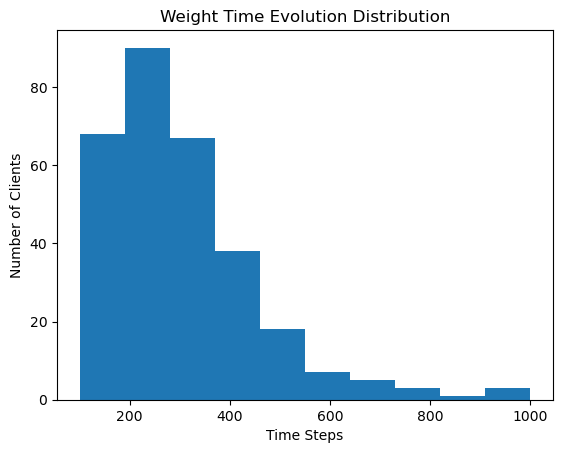

In [70]:
plt.hist(record["taus"][0])
plt.title("Weight Time Evolution Distribution")
plt.xlabel("Time Steps")
plt.ylabel("Number of Clients")
plt.show()

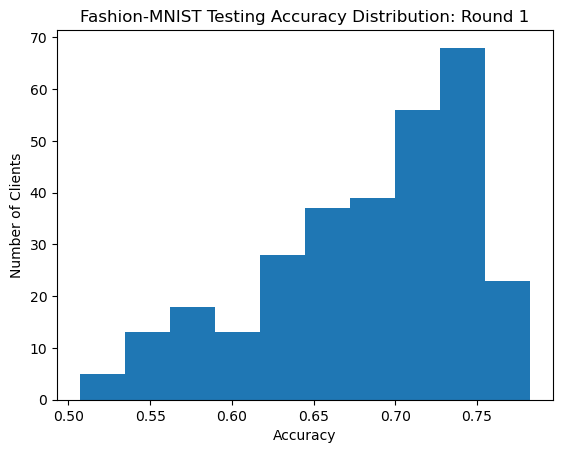

In [39]:
plt.hist(record["testing_accuracy"])
plt.title("Fashion-MNIST Testing Accuracy Distribution: Round 1")
plt.xlabel("Accuracy")
plt.ylabel("Number of Clients")
plt.show()

In [45]:
record["models"] = model_dict

In [46]:
save_record(config, record)

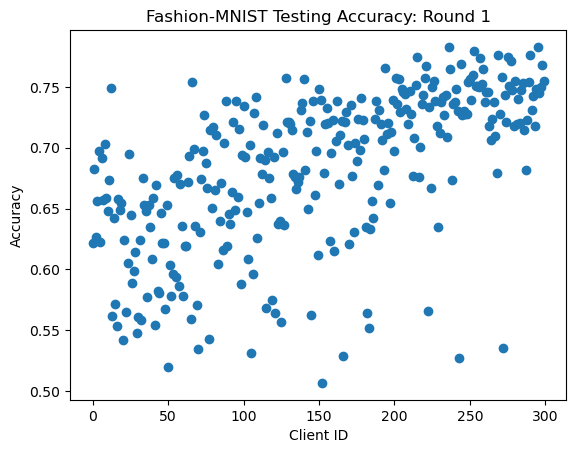

In [54]:
plt.scatter(np.arange(0, len(record["testing_accuracy"][0])),record["testing_accuracy"][0])
plt.title("Fashion-MNIST Testing Accuracy: Round 1")
plt.xlabel("Client ID")
plt.ylabel("Accuracy")
plt.show()

In [52]:
np.mean(record["testing_accuracy"][0])

0.6829766494035721

In [57]:
# Read .dat record file
fp = "./11_13.dat"
with open(fp, 'rb') as file:
    record_load = pickle.load(file)
record_load.keys()


dict_keys(['num_parameters', 'batch_size', 'lr', 'taus', 'testing_accuracy', 'loss', 'rounds', 'iid', 'model_accs_per_round', 'model_num_training_rounds', 'models', 'epochs'])